# Imports

In [616]:
from collections import Counter
import glob
from itertools import chain
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from tqdm import tqdm

# Read rfam2go

In [2]:
rfam2go_original = pd.read_csv('ftp://ftp.ebi.ac.uk/pub/databases/Rfam/CURRENT/rfam2go/rfam2go', header=None, sep=' > ')
print(rfam2go_original.shape)
rfam2go_original.head()

df1 = rfam2go_original[0].str.split(expand=True).rename(columns={0: 'rfam_id_full', 1: 'rfam_description'})
df1.head()

df2 = rfam2go_original[1].str.split(' ; ', expand=True).rename(columns={0: 'go_description', 1: 'go_id'})
df2.head()

## Make a cleaned rfam2go table

rfam2go = pd.concat([df1, df2], axis=1)
rfam2go['rfam_id'] = rfam2go.rfam_id_full.str.split(':').str[1]
rfam2go = rfam2go.set_index('rfam_id')
rfam2go.head()

# Pick a sample that may even be a noncoding rna --> few protein coding reads, more noncoding reads

In [9]:
outdir = '/mnt/ibm_sm/olga/tabula-microcebus/analyses/predictorthologs/utar-rerun-2020-05-22-rmdup-v2-mammals'
!ls -lha $outdir

total 1.4M
drwxr-xr-x 12 olga czb 4.0K Jun 22 16:48 .
drwxr-xr-x  8 olga czb 4.0K Jun 22 09:37 ..
drwxr-xr-x  3 olga czb 4.0K Jun 22 09:52 diamond
drwxr-xr-x  4 olga czb 4.0K Jun 22 09:38 fastp
drwxr-xr-x  3 olga czb 256K Jun 22 10:35 fastqc
drwxr-xr-x  3 olga czb 4.0K Jun 22 09:58 infernal
drwxr-xr-x  2 olga czb 128K Jun 22 09:46 intersect_fastqs
drwxr-xr-x  4 olga czb 4.0K Jun 22 16:48 MultiQC
drwxr-xr-x  2 olga czb 4.0K Jun 22 09:37 ncbi_refseq
drwxr-xr-x  2 olga czb 4.0K Jun 22 17:00 pipeline_info
drwxr-xr-x  2 olga czb 4.0K Jun 22 09:37 sencha
drwxr-xr-x  2 olga czb 1.0M Jun 22 10:05 translate


In [10]:
def read_coding_noncoding_sizes(predictorthologs_outdir):

    lines = []

    for noncoding in glob.iglob(f'{predictorthologs_outdir}/translate/*noncoding*.fasta'):
        basename = os.path.basename(noncoding)
        coding = noncoding.replace('noncoding', 'coding')
        sample_id = basename.split('__')[0]
        noncoding_size = os.stat(noncoding).st_size
        coding_size = os.stat(coding).st_size
        lines.append([sample_id, noncoding_size, coding_size])

    df = pd.DataFrame(lines, columns=['sample_id', 'noncoding_size', 'coding_size'])
    print(df.shape)
    return df

nucleotide_read_sizes_v2_mammals = read_coding_noncoding_sizes(outdir)
nucleotide_read_sizes_v2_mammals.head()

(1970, 3)


,sample_id,noncoding_size,coding_size
0,NC-033665.1-74760899-74761099-+-11192-0,29415,0
1,NC-033681.1-26955749-26959949-+-336-0,403053,110
2,NC-033666.1-12322549-12322749---212-0,115393,0
3,NC-033667.1-80669399-80679199-+-352-0,54097,0
4,NC-033660.1-74138199-74141099-+-63-0,97172,0


In [14]:
infernal_results_folder = f'{outdir}/infernal/cmsearch/'

In [28]:
ls -lha $infernal_results_folder | head

total 222M
drwxr-xr-x 2 olga czb 128K Jun 22 17:00 ./
drwxr-xr-x 3 olga czb 4.0K Jun 22 09:58 ../
-rw-r--r-- 1 olga czb  39K Jun 22 14:40 NC-033660.1-100839949-100841299---38-0.txt
-rw-r--r-- 1 olga czb  20K Jun 22 11:02 NC-033660.1-101997299-101998899-+-1244-0.txt
-rw-r--r-- 1 olga czb  94K Jun 22 15:01 NC-033660.1-103044949-103045399---164-0.txt
-rw-r--r-- 1 olga czb  69K Jun 22 15:33 NC-033660.1-1031849-1032749---576-0.txt
-rw-r--r-- 1 olga czb  82K Jun 22 11:23 NC-033660.1-103461149-103463199---710-0.txt
-rw-r--r-- 1 olga czb  79K Jun 22 16:18 NC-033660.1-103464149-103465799---109-0.txt
-rw-r--r-- 1 olga czb 109K Jun 22 10:50 NC-033660.1-103891199-103891749-+-1492-0.txt
ls: write error


In [29]:
infernal_columns = ['target name         accession query name           accession mdl mdl from   mdl to seq from   seq to strand trunc pass   gc  bias  score   E-value inc description of target']

In [17]:
! head $infernal_results_folder/NC-033662.1-96455849-96456799-+-2430-0.txt

#target name         accession query name           accession mdl mdl from   mdl to seq from   seq to strand trunc pass   gc  bias  score   E-value inc description of target
#------------------- --------- -------------------- --------- --- -------- -------- -------- -------- ------ ----- ---- ---- ----- ------ --------- --- ---------------------
A00111:71:H3TTFDMXX:1:2281:15365:36338 -         tRNA                 RF00005    cm        1       71        4       74      +    no    1 0.58   0.0   53.4   1.8e-12 !   translation_frame: 3 jaccard: 0.0
A00111:71:H3TTFDMXX:1:2281:15365:36338 -         tRNA                 RF00005    cm        1       71        4       74      +    no    1 0.58   0.0   53.4   1.8e-12 !   translation_frame: -2 jaccard: 0.0
A00111:212:HGMF5DMXX:2:1256:1045:32737  -         Metazoa_SRP          RF00017    cm        1       79       80        1      -    3'    3 0.60   0.0   41.1     2e-10 !   translation_frame: 2 jaccard: 0.19047619047619047
A00111:43:H252WDMXX:1:

In [18]:
pd.options.display.max_columns = 50

In [19]:
INFERNAL_COLUMN_NAMES = [
        'target_name', 'target_accession', 'query_name', 'query_accession', 
        'model', 'model_from', 'model_to',
        'seq_from', 'seq_to', 'strand', 'trunc', 'pass', 
        'gc', 'bias', 'score', 'e_value', 'inc', 
        'desc1', 'translation_frame', 'desc2', 'jaccard'
    ]
    
def read_infernal_results(filename):
    df = pd.read_csv(filename, comment='#', sep='\s+', header=None, names=INFERNAL_COLUMN_NAMES)
    return df

In [20]:


infernal_output = read_infernal_results(f'{infernal_results_folder}/NC-033663.1-17918799-17920049-+-5142-0.txt')
print(infernal_output.shape)
infernal_output.head()

(308, 21)


,target_name,target_accession,query_name,query_accession,model,model_from,model_to,seq_from,seq_to,strand,trunc,pass,gc,bias,score,e_value,inc,desc1,translation_frame,desc2,jaccard
0,A00111:61:H3FYJDMXX:2:1463:15808:21136,-,Metazoa_SRP,RF00017,cm,1,53,37,90,+,3',3,0.69,0.0,31.0,4.200000e-08,!,translation_frame:,-2,jaccard:,0.000000
1,A00111:192:HFVL5DMXX:2:2184:18629:3975,-,Metazoa_SRP,RF00017,cm,1,68,23,90,+,3',3,0.68,0.0,29.8,9.300000e-08,!,translation_frame:,1,jaccard:,0.000000
2,A00111:192:HFVL5DMXX:2:2184:18629:3975,-,Metazoa_SRP,RF00017,cm,1,68,23,90,+,3',3,0.68,0.0,29.8,9.300000e-08,!,translation_frame:,3,jaccard:,0.142857
3,A00111:192:HFVL5DMXX:2:2184:18629:3975,-,Metazoa_SRP,RF00017,cm,1,68,23,90,+,3',3,0.68,0.0,29.8,9.300000e-08,!,translation_frame:,-2,jaccard:,0.000000
4,A00111:43:H252WDMXX:1:1455:18602:10848,-,Metazoa_SRP,RF00017,cm,1,63,28,90,+,3',3,0.67,0.0,28.9,1.600000e-07,!,translation_frame:,2,jaccard:,0.047619


In [21]:
infernal_output.describe()

,model_from,model_to,seq_from,seq_to,pass,gc,bias,score,e_value,translation_frame,jaccard
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,3.080000e+02,308.000000,308.000000
mean,34.685065,79.808442,41.178571,61.818182,3.136364,0.499416,2.776299,10.669156,1.626926e+00,-0.009740,0.033656
std,41.747592,53.926349,27.890968,31.568540,0.835438,0.106855,3.942881,5.794757,2.042913e+00,2.231672,0.093415
min,1.000000,19.000000,1.000000,1.000000,1.000000,0.110000,0.000000,-0.300000,4.200000e-08,-3.000000,0.000000
25%,1.000000,40.000000,15.000000,37.000000,3.000000,0.470000,0.000000,7.700000,1.270000e-01,-2.000000,0.000000
50%,10.000000,68.000000,45.000000,80.000000,3.000000,0.500000,0.300000,9.400000,9.600000e-01,1.000000,0.000000
75%,59.000000,107.000000,67.000000,90.000000,4.000000,0.540000,4.400000,11.625000,2.800000e+00,2.000000,0.000000
max,114.000000,325.000000,90.000000,90.000000,6.000000,0.690000,12.500000,31.000000,9.200000e+00,3.000000,0.761905


In [22]:
infernal_output.query('e_value < 1e-10').query_name.value_counts()

Series([], Name: query_name, dtype: int64)

In [23]:
infernal_output.nsmallest(10, 'e_value')

,target_name,target_accession,query_name,query_accession,model,model_from,model_to,seq_from,seq_to,strand,trunc,pass,gc,bias,score,e_value,inc,desc1,translation_frame,desc2,jaccard
0,A00111:61:H3FYJDMXX:2:1463:15808:21136,-,Metazoa_SRP,RF00017,cm,1,53,37,90,+,3',3,0.69,0.0,31.0,4.200000e-08,!,translation_frame:,-2,jaccard:,0.000000
1,A00111:192:HFVL5DMXX:2:2184:18629:3975,-,Metazoa_SRP,RF00017,cm,1,68,23,90,+,3',3,0.68,0.0,29.8,9.300000e-08,!,translation_frame:,1,jaccard:,0.000000
2,A00111:192:HFVL5DMXX:2:2184:18629:3975,-,Metazoa_SRP,RF00017,cm,1,68,23,90,+,3',3,0.68,0.0,29.8,9.300000e-08,!,translation_frame:,3,jaccard:,0.142857
3,A00111:192:HFVL5DMXX:2:2184:18629:3975,-,Metazoa_SRP,RF00017,cm,1,68,23,90,+,3',3,0.68,0.0,29.8,9.300000e-08,!,translation_frame:,-2,jaccard:,0.000000
4,A00111:43:H252WDMXX:1:1455:18602:10848,-,Metazoa_SRP,RF00017,cm,1,63,28,90,+,3',3,0.67,0.0,28.9,1.600000e-07,!,translation_frame:,2,jaccard:,0.047619
5,A00111:43:H252WDMXX:1:1455:18602:10848,-,Metazoa_SRP,RF00017,cm,1,63,28,90,+,3',3,0.67,0.0,28.9,1.600000e-07,!,translation_frame:,3,jaccard:,0.047619
6,A00111:211:HGKCVDMXX:1:1255:2980:33364,-,Metazoa_SRP,RF00017,cm,1,71,20,90,+,3',3,0.65,0.0,28.1,2.700000e-07,!,translation_frame:,1,jaccard:,0.000000
7,A00111:211:HGKCVDMXX:1:1255:2980:33364,-,Metazoa_SRP,RF00017,cm,1,71,20,90,+,3',3,0.65,0.0,28.1,2.700000e-07,!,translation_frame:,-2,jaccard:,0.000000
8,A00111:71:H3TTFDMXX:2:2344:23023:24831,-,Metazoa_SRP,RF00017,cm,1,65,26,90,+,3',3,0.66,0.0,27.6,3.700000e-07,!,translation_frame:,1,jaccard:,0.000000
9,A00111:71:H3TTFDMXX:2:2344:23023:24831,-,Metazoa_SRP,RF00017,cm,1,65,26,90,+,3',3,0.66,0.0,27.6,3.700000e-07,!,translation_frame:,3,jaccard:,0.142857


In [24]:

dfs = []

for filename in glob.glob(f'{infernal_results_folder}/*.txt'):
    df = read_infernal_results(filename)
    basename = os.path.basename(filename)
    region_id = basename.split('.txt')[0]
    df['region_id'] = region_id
    dfs.append(df)
infernal_results_original = pd.concat(dfs)
print(infernal_results_original.shape)
infernal_results_original.head()

(1064016, 22)


,target_name,target_accession,query_name,query_accession,model,model_from,model_to,seq_from,seq_to,strand,trunc,pass,gc,bias,score,e_value,inc,desc1,translation_frame,desc2,jaccard,utar
0,A00111:71:H3TTFDMXX:1:2147:13485:5243,-,Metazoa_SRP,RF00017,cm,1,81,10,90,+,3',3,0.64,0.0,47.5,8.500000e-12,!,translation_frame:,2,jaccard:,0.047619,NC-033665.1-60754699-60757649-+-12401-0
1,A00111:71:H3TTFDMXX:1:2147:13485:5243,-,Metazoa_SRP,RF00017,cm,1,81,10,90,+,3',3,0.64,0.0,47.5,8.500000e-12,!,translation_frame:,-3,jaccard:,0.095238,NC-033665.1-60754699-60757649-+-12401-0
2,A00111:61:H3FYJDMXX:1:2348:31620:25817,-,Metazoa_SRP,RF00017,cm,1,84,6,90,+,3',3,0.65,0.0,45.8,2.500000e-11,!,translation_frame:,-3,jaccard:,0.142857,NC-033665.1-60754699-60757649-+-12401-0
3,A00111:212:HGMF5DMXX:2:1143:3631:31203,-,Metazoa_SRP,RF00017,cm,1,78,12,90,+,3',3,0.61,0.0,44.2,7.000000e-11,!,translation_frame:,2,jaccard:,0.000000,NC-033665.1-60754699-60757649-+-12401-0
4,A00111:212:HGMF5DMXX:2:1143:3631:31203,-,Metazoa_SRP,RF00017,cm,1,78,12,90,+,3',3,0.61,0.0,44.2,7.000000e-11,!,translation_frame:,-1,jaccard:,0.000000,NC-033665.1-60754699-60757649-+-12401-0


## Add inverse e value for weighting

In [31]:
infernal_results_original['e_value_inverse'] = np.divide(1, infernal_results_original['e_value'])
infernal_results_original.head()

,target_name,target_accession,query_name,query_accession,model,model_from,model_to,seq_from,seq_to,strand,trunc,pass,gc,bias,score,e_value,inc,desc1,translation_frame,desc2,jaccard,utar,e_value_inverse
0,A00111:71:H3TTFDMXX:1:2147:13485:5243,-,Metazoa_SRP,RF00017,cm,1,81,10,90,+,3',3,0.64,0.0,47.5,8.500000e-12,!,translation_frame:,2,jaccard:,0.047619,NC-033665.1-60754699-60757649-+-12401-0,1.176471e+11
1,A00111:71:H3TTFDMXX:1:2147:13485:5243,-,Metazoa_SRP,RF00017,cm,1,81,10,90,+,3',3,0.64,0.0,47.5,8.500000e-12,!,translation_frame:,-3,jaccard:,0.095238,NC-033665.1-60754699-60757649-+-12401-0,1.176471e+11
2,A00111:61:H3FYJDMXX:1:2348:31620:25817,-,Metazoa_SRP,RF00017,cm,1,84,6,90,+,3',3,0.65,0.0,45.8,2.500000e-11,!,translation_frame:,-3,jaccard:,0.142857,NC-033665.1-60754699-60757649-+-12401-0,4.000000e+10
3,A00111:212:HGMF5DMXX:2:1143:3631:31203,-,Metazoa_SRP,RF00017,cm,1,78,12,90,+,3',3,0.61,0.0,44.2,7.000000e-11,!,translation_frame:,2,jaccard:,0.000000,NC-033665.1-60754699-60757649-+-12401-0,1.428571e+10
4,A00111:212:HGMF5DMXX:2:1143:3631:31203,-,Metazoa_SRP,RF00017,cm,1,78,12,90,+,3',3,0.61,0.0,44.2,7.000000e-11,!,translation_frame:,-1,jaccard:,0.000000,NC-033665.1-60754699-60757649-+-12401-0,1.428571e+10


## Do a weighted mode to get most likely sequence

In [39]:
from sklearn.utils.extmath import weighted_mode

def most_likely_sequence(df, id_col='query_accession', weight_col='e_value_inverse'):
    ids = df[id_col]
    weights = df[weight_col]
    vals, scores = weighted_mode(ids, weights)
    val = vals[0]
    score = scores[0]
    series = pd.Series([val, score], index=[id_col, weight_col+'__weighted'])
    return series

# infernal_results_original.groupby('utar').apply(most_likely_sequence)

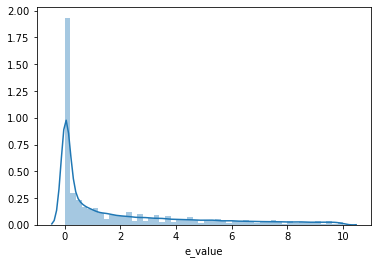

In [47]:
sns.distplot(infernal_results_original.e_value)

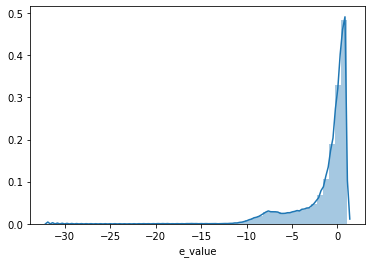

In [48]:
sns.distplot(np.log10(infernal_results_original.e_value))

## Get only the utars that have a "good" hit - where 

> The ! or ? that precedes the E-value indicates whether the hit does (!) or does not (?) satisfy the inclusion threshold for the search. Inclusion thresholds are used to determine what matches should be considered to be “true”, as opposed to reporting thresholds that determine what matches will be reported

In [167]:
csv_outdir = '/home/olga/googledrive/TabulaMicrocebus/analysis/utar-predictorthologs'
infernal_results_original.to_csv(f'{csv_outdir}/noncoding_infernal_results.csv')

In [40]:
infernal_results_original_good_evalue = infernal_results_original.query('inc == "!"')
print(infernal_results_original_good_evalue.shape)
infernal_results_original_good_evalue.head()

(260008, 23)


,target_name,target_accession,query_name,query_accession,model,model_from,model_to,seq_from,seq_to,strand,trunc,pass,gc,bias,score,e_value,inc,desc1,translation_frame,desc2,jaccard,utar,e_value_inverse
0,A00111:71:H3TTFDMXX:1:2147:13485:5243,-,Metazoa_SRP,RF00017,cm,1,81,10,90,+,3',3,0.64,0.0,47.5,8.500000e-12,!,translation_frame:,2,jaccard:,0.047619,NC-033665.1-60754699-60757649-+-12401-0,1.176471e+11
1,A00111:71:H3TTFDMXX:1:2147:13485:5243,-,Metazoa_SRP,RF00017,cm,1,81,10,90,+,3',3,0.64,0.0,47.5,8.500000e-12,!,translation_frame:,-3,jaccard:,0.095238,NC-033665.1-60754699-60757649-+-12401-0,1.176471e+11
2,A00111:61:H3FYJDMXX:1:2348:31620:25817,-,Metazoa_SRP,RF00017,cm,1,84,6,90,+,3',3,0.65,0.0,45.8,2.500000e-11,!,translation_frame:,-3,jaccard:,0.142857,NC-033665.1-60754699-60757649-+-12401-0,4.000000e+10
3,A00111:212:HGMF5DMXX:2:1143:3631:31203,-,Metazoa_SRP,RF00017,cm,1,78,12,90,+,3',3,0.61,0.0,44.2,7.000000e-11,!,translation_frame:,2,jaccard:,0.000000,NC-033665.1-60754699-60757649-+-12401-0,1.428571e+10
4,A00111:212:HGMF5DMXX:2:1143:3631:31203,-,Metazoa_SRP,RF00017,cm,1,78,12,90,+,3',3,0.61,0.0,44.2,7.000000e-11,!,translation_frame:,-1,jaccard:,0.000000,NC-033665.1-60754699-60757649-+-12401-0,1.428571e+10


## WRite good evalue hits to file

In [743]:
def write_tables(df, prefix, formats=('csv', 'parquet')):
    for fmt in formats:
        filename = f'{prefix}.{fmt}'
        if fmt == 'csv':
            df.to_csv(filename)
        if fmt == 'parquet':
            df.to_parquet(filename)
write_tables(infernal_results_original_good_evalue, '/home/olga/data_sm/tabula-microcebus/analyses/de-novo-orthology/uTAR/utar_predictions__rna_per_read')

In [41]:
infernal_results_original_good_evalue_likely_rnas = infernal_results_original_good_evalue.groupby('utar').apply(most_likely_sequence)
print(infernal_results_original_good_evalue_likely_rnas.shape)
infernal_results_original_good_evalue_likely_rnas.head()

(1950, 2)


,query_accession,e_value_inverse__weighted
utar,,
NC-033660.1-100839949-100841299---38-0,RF00017,5.659683e+09
NC-033660.1-101997299-101998899-+-1244-0,RF00017,4.960531e+09
NC-033660.1-103044949-103045399---164-0,RF00015,1.187797e+17
NC-033660.1-1031849-1032749---576-0,RF00017,8.580173e+09
NC-033660.1-103461149-103463199---710-0,RF00017,8.862436e+12


In [83]:
rfam2go['go_description'].value_counts()

GO:RNA processing                                              790
GO:nucleolus                                                   779
GO:gene silencing by miRNA                                     528
GO:micro-ribonucleoprotein complex                             522
GO:regulation of gene expression                                71
                                                              ... 
GO:mRNA 3'-end processing by stem-loop binding and cleavage      1
GO:thiamine pyrophosphate binding                                1
GO:response to magnesium ion                                     1
GO:pyrimidine nucleobase transport                               1
GO:leucine biosynthetic process                                  1
Name: go_description, Length: 239, dtype: int64

## Join with rfam2go

In [51]:
# rfam_id_to_description = rfam2go['rfam_description'].drop_duplicates()

infernal_results_original_good_evalue_likely_rnas_rfam2go = infernal_results_original_good_evalue_likely_rnas.join(rfam2go, on='query_accession')
print(infernal_results_original_good_evalue_likely_rnas_rfam2go.shape)
infernal_results_original_good_evalue_likely_rnas_rfam2go.head()

(3906, 6)


,query_accession,e_value_inverse__weighted,rfam_id_full,rfam_description,go_description,go_id
utar,,,,,,
NC-033660.1-100839949-100841299---38-0,RF00017,5.659683e+09,Rfam:RF00017,Metazoa_SRP,"GO:signal recognition particle, endoplasmic re...",GO:0005786
NC-033660.1-100839949-100841299---38-0,RF00017,5.659683e+09,Rfam:RF00017,Metazoa_SRP,GO:SRP-dependent cotranslational protein targe...,GO:0006617
NC-033660.1-101997299-101998899-+-1244-0,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,"GO:signal recognition particle, endoplasmic re...",GO:0005786
NC-033660.1-101997299-101998899-+-1244-0,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,GO:SRP-dependent cotranslational protein targe...,GO:0006617
NC-033660.1-103044949-103045399---164-0,RF00015,1.187797e+17,Rfam:RF00015,U4,GO:spliceosomal tri-snRNP complex assembly,GO:0000244


In [52]:
csv_outdir = '/home/olga/googledrive/TabulaMicrocebus/analysis/utar-predictorthologs'
infernal_results_original_good_evalue_likely_rnas_rfam2go.to_csv(f'{csv_outdir}/noncoding_rna_weighted_mode_infernal_cmsearch_rfam_results_rfam2go.csv')

## Remove gene ontology annotation, just leave rfam description

In [54]:
infernal_results_original_good_evalue_likely_rnas_no_go = infernal_results_original_good_evalue_likely_rnas_rfam2go.drop(
    ['go_description', 'go_id'], axis=1)
infernal_results_original_good_evalue_likely_rnas_no_go = infernal_results_original_good_evalue_likely_rnas_no_go.drop_duplicates()
print(infernal_results_original_good_evalue_likely_rnas_no_go.shape)
infernal_results_original_good_evalue_likely_rnas_no_go.head()

(1937, 4)


,query_accession,e_value_inverse__weighted,rfam_id_full,rfam_description
utar,,,,
NC-033660.1-100839949-100841299---38-0,RF00017,5.659683e+09,Rfam:RF00017,Metazoa_SRP
NC-033660.1-101997299-101998899-+-1244-0,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP
NC-033660.1-103044949-103045399---164-0,RF00015,1.187797e+17,Rfam:RF00015,U4
NC-033660.1-1031849-1032749---576-0,RF00017,8.580173e+09,Rfam:RF00017,Metazoa_SRP
NC-033660.1-103461149-103463199---710-0,RF00017,8.862436e+12,Rfam:RF00017,Metazoa_SRP


In [66]:
rfam_counts = infernal_results_original_good_evalue_likely_rnas_no_go['rfam_description'].value_counts()
rfam_counts = rfam_counts.sort_values(ascending=False)
rfam_counts

Metazoa_SRP         1772
SCARNA7               44
SOX2OT_exon2          13
LSU_rRNA_eukarya      13
U6                    10
snoU13                 6
U4                     4
U1                     4
mir-574                4
tRNA                   3
mir-692                3
5S_rRNA                3
mir-147                2
GP_knot1               2
U2                     2
SNORA42                2
mir-328                2
mir-214                2
NEAT1_3                2
SCARNA2                2
SSU_rRNA_eukarya       2
TtnuCD13               1
snoU82P                1
mir-650                1
mir-423                1
SCARNA14               1
mir-609                1
mir-197                1
NPPA-AS1_2             1
mir-1937               1
Rota_CRE               1
DdR17                  1
SNORD111               1
mir-558                1
SNORA51                1
sno_ZL1                1
Name: rfam_description, dtype: int64

## Plot the top categories, colored by gene ontology

In [88]:
go_description_counts = infernal_results_original_good_evalue_likely_rnas_rfam2go['go_description'].value_counts()
go_description_counts.head()

GO:signal recognition particle, endoplasmic reticulum targeting                                1783
GO:SRP-dependent cotranslational protein targeting to membrane, signal sequence recognition    1783
GO:nucleolus                                                                                     62
GO:RNA processing                                                                                62
GO:structural constituent of ribosome                                                            19
Name: go_description, dtype: int64

### Use the go description that appears most often

In [108]:
rows = infernal_results_original_good_evalue_likely_rnas_rfam2go.rfam_description.str.startswith("U").fillna(False)
infernal_results_original_good_evalue_likely_rnas_rfam2go.loc[rows, 'go_description'].value_counts()

GO:spliceosomal tri-snRNP complex assembly     14
GO:formation of quadruple SL/U4/U5/U6 snRNP    14
GO:U4/U6 x U5 tri-snRNP complex                14
GO:U4 snRNA binding                            10
GO:U6 snRNP                                    10
GO:U1 snRNP                                     4
GO:pre-mRNA 5'-splice site binding              4
GO:mRNA 5'-splice site recognition              4
GO:U6 snRNA binding                             4
GO:U4 snRNP                                     4
GO:U2 snRNP                                     2
GO:pre-mRNA branch point binding                2
GO:mRNA branch site recognition                 2
Name: go_description, dtype: int64

In [89]:
rfam_description_to_most_common_go = infernal_results_original_good_evalue_likely_rnas_rfam2go.groupby('rfam_description').apply(
    lambda x: go_description_counts[x['go_description']].argmax())
rfam_description_to_most_common_go

/home/olga/miniconda3/envs/tabula-microcebus-v2/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


rfam_description
5S_rRNA                         GO:structural constituent of ribosome
DdR17                                                    GO:nucleolus
GP_knot1                           GO:viral translational readthrough
LSU_rRNA_eukarya                GO:structural constituent of ribosome
Metazoa_SRP         GO:signal recognition particle, endoplasmic re...
NEAT1_3                                            GO:protein binding
NPPA-AS1_2                                            GO:mRNA binding
Rota_CRE                                           GO:RNA replication
SCARNA14                                                 GO:nucleolus
SCARNA2                                                  GO:nucleolus
SCARNA7                                                  GO:nucleolus
SNORA42                                                  GO:nucleolus
SNORA51                                                  GO:nucleolus
SNORD111                                                 GO:nucleolus
SOX

In [111]:
rfam_description_to_most_common_go.to_dict()

{'5S_rRNA': 'GO:structural constituent of ribosome',
 'DdR17': 'GO:nucleolus',
 'GP_knot1': 'GO:viral translational readthrough',
 'LSU_rRNA_eukarya': 'GO:structural constituent of ribosome',
 'Metazoa_SRP': 'GO:signal recognition particle, endoplasmic reticulum targeting',
 'NEAT1_3': 'GO:protein binding',
 'NPPA-AS1_2': 'GO:mRNA binding',
 'Rota_CRE': 'GO:RNA replication',
 'SCARNA14': 'GO:nucleolus',
 'SCARNA2': 'GO:nucleolus',
 'SCARNA7': 'GO:nucleolus',
 'SNORA42': 'GO:nucleolus',
 'SNORA51': 'GO:nucleolus',
 'SNORD111': 'GO:nucleolus',
 'SOX2OT_exon2': 'GO:multicellular organism development',
 'SSU_rRNA_eukarya': 'GO:structural constituent of ribosome',
 'TtnuCD13': 'GO:nucleolus',
 'U1': "GO:mRNA 5'-splice site recognition",
 'U2': 'GO:mRNA branch site recognition',
 'U4': 'GO:spliceosomal tri-snRNP complex assembly',
 'U6': 'GO:spliceosomal tri-snRNP complex assembly',
 'mir-147': 'GO:micro-ribonucleoprotein complex',
 'mir-1937': 'GO:micro-ribonucleoprotein complex',
 'mir-197

In [113]:
rfam_categories = pd.Series({
    '5S_rRNA': 'translation',
 'DdR17': 'snoRNA',
 'GP_knot1': 'viral',
 'LSU_rRNA_eukarya': 'translation',
 'Metazoa_SRP': 'translation',
 'NEAT1_3': 'lncRNA',
 'NPPA-AS1_2': 'lncRNA',
 'Rota_CRE': 'viral',
 'SCARNA14': 'snoRNA: Cajal bodies',
 'SCARNA2': 'snoRNA: Cajal bodies',
 'SCARNA7': 'snoRNA: Cajal bodies',
 'SNORA42': 'snoRNA',
 'SNORA51': 'snoRNA',
 'SNORD111': 'snoRNA',
 'SOX2OT_exon2': 'lncRNA',
 'SSU_rRNA_eukarya': 'translation',
 'TtnuCD13': 'snoRNA',
 'U1': "spliceosome",
 'U2': 'spliceosome',
 'U4': 'spliceosome',
 'U6': 'spliceosome',
 'mir-147': 'microRNA',
 'mir-1937': 'microRNA',
 'mir-197': 'microRNA',
 'mir-214': 'microRNA',
 'mir-328': 'microRNA',
 'mir-423': 'microRNA',
 'mir-558': 'microRNA',
 'mir-574': 'microRNA',
 'mir-609': 'microRNA',
 'mir-650': 'microRNA',
 'mir-692': 'microRNA',
 'snoU13': 'snoRNA',
 'snoU82P': 'snoRNA',
 'sno_ZL1': 'snoRNA',
 'tRNA': 'translation'
})

n_rfam_categories: 7


{'5S_rRNA': (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 'DdR17': (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 'GP_knot1': (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 'LSU_rRNA_eukarya': (0.9019607843137255,
  0.6705882352941176,
  0.00784313725490196),
 'Metazoa_SRP': (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 'NEAT1_3': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 'NPPA-AS1_2': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 'Rota_CRE': (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 'SCARNA14': (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 'SCARNA2': (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 'SCARNA7': (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 'SNORA42': (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 'SNORA51': (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 'SNORD111

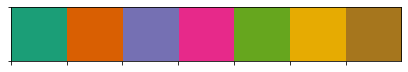

In [123]:
rfam_categories_unique = sorted(rfam_categories.unique())
n_rfam_categories = len(rfam_categories_unique)
print(f'n_rfam_categories: {n_rfam_categories}')

palette = sns.color_palette("Dark2", n_rfam_categories)
sns.palplot(palette)

rfam_category_to_color = dict(zip(rfam_categories_unique, palette))
rfam_to_color = {k: rfam_category_to_color[v] for k, v in rfam_categories.items()}
rfam_to_color

In [125]:
for x in rfam_categories_unique:
    print(x)

lncRNA
microRNA
snoRNA
snoRNA: Cajal bodies
spliceosome
translation
viral


In [372]:
infernal_results_original_good_evalue_likely_rnas_no_go.shape

(1937, 5)

In [139]:
infernal_results_original_good_evalue_likely_rnas_no_go['rfam_category'] = \
    infernal_results_original_good_evalue_likely_rnas_no_go.rfam_description.map(rfam_categories)
rfam_category_counts = infernal_results_original_good_evalue_likely_rnas_no_go.rfam_category.value_counts()
rfam_category_counts = rfam_cateogory_counts.sort_values(ascending=False)
rfam_category_counts

translation             1793
snoRNA: Cajal bodies      47
spliceosome               20
microRNA                  19
lncRNA                    16
snoRNA                    14
viral                      3
Name: rfam_category, dtype: int64

In [257]:
infernal_results_original_good_evalue_likely_rnas_no_go

,query_accession,e_value_inverse__weighted,rfam_id_full,rfam_description,rfam_category
utar,,,,,
NC-033660.1-100839949-100841299---38-0,RF00017,5.659683e+09,Rfam:RF00017,Metazoa_SRP,translation
NC-033660.1-101997299-101998899-+-1244-0,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,translation
NC-033660.1-103044949-103045399---164-0,RF00015,1.187797e+17,Rfam:RF00015,U4,spliceosome
NC-033660.1-1031849-1032749---576-0,RF00017,8.580173e+09,Rfam:RF00017,Metazoa_SRP,translation
NC-033660.1-103461149-103463199---710-0,RF00017,8.862436e+12,Rfam:RF00017,Metazoa_SRP,translation
...,...,...,...,...,...
NW-017968525.1-372349-381449---607-0,RF00017,1.764018e+11,Rfam:RF00017,Metazoa_SRP,translation
NW-017968525.1-70499-72149---1597-0,RF00017,6.367365e+08,Rfam:RF00017,Metazoa_SRP,translation
NW-017968532.1-117249-127599-+-6640-0,RF02157,2.472743e+03,Rfam:RF02157,NPPA-AS1_2,lncRNA


In [164]:
csv_outdir = '/home/olga/googledrive/TabulaMicrocebus/analysis/utar-predictorthologs'
infernal_results_original_good_evalue_likely_rnas_no_go.to_csv(f'{csv_outdir}/noncoding_rna_weighted_mode_infernal_cmsearch_rfam_results_no_gene_ontology.csv')

## Plot number of categories

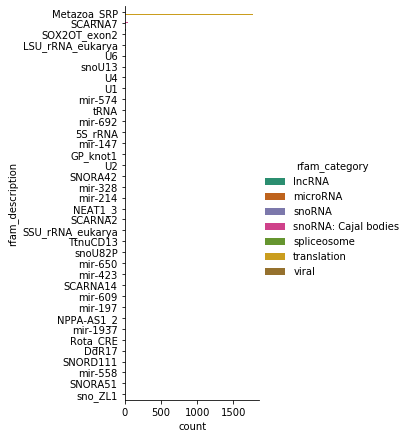

In [131]:
g = sns.catplot(data=infernal_results_original_good_evalue_likely_rnas_no_go, 
                y='rfam_description', kind='count', height=6, aspect=.75, 
                order=rfam_counts.index, hue='rfam_category',
                palette=rfam_category_to_color,
#                 edgecolor='k',
#                 color='grey'
               )
g.set(xscale='log')
sns.despine(bottom=True, top=False)
for ax in g.axes.flat:
    ax.xaxis.set_label_position('top')

### Barplot of whole rfam descriptions

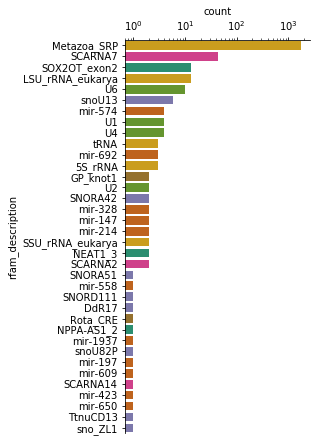

In [418]:

def plot_rfam_counts(df, y='rfam_description', height=6, aspect=.75, order=None, **kwargs):
    if order is None:
        order = df[y].value_counts()
    if y == 'rfam_description':
        palette = rfam_to_color
    elif y == 'rfam_category':
        palette = rfam_category_to_color
    
    g = sns.catplot(data=df, 
                    y=y, kind='count', height=height, aspect=aspect, 
                    order=order.index,
                    palette=palette,
    #                 edgecolor='k',
    #                 color='grey'
                   )
    g.set(xscale='log')
    sns.despine(bottom=True, top=False)
    for ax in g.axes.flat:
        ax.xaxis.set_label_position('top')
        

plot_rfam_counts(infernal_results_original_good_evalue_likely_rnas_no_go, y='rfam_description', height=6, aspect=.75,  **kwargs)

### Barplot of manual rfam categories

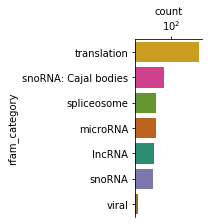

In [419]:
plot_rfam_counts(infernal_results_original_good_evalue_likely_rnas_no_go, y='rfam_category', height=3, aspect=1,  **kwargs)

In [141]:
csv_outdir = '/home/olga/googledrive/TabulaMicrocebus/analysis/utar-predictorthologs'
infernal_results_original_good_evalue_likely_rnas_rfam2go.to_csv(f'{csv_outdir}/noncoding_rna_weighted_mode_infernal_cmsearch_rfam_results_no_gene_ontology.csv')

### Add cell type information

In [268]:
utar_to_celltype = pd.read_csv(f'{utar_dir}/cellTypeMarkersUTarsPeaks.bed', sep='\t', header=None, index_col=3)
utar_to_celltype.head()

,0,1,2,4,5,6,7,8,9,10,11,12,13,14,15
3,,,,,,,,,,,,,,,
NW-017968608.1-2349-3349---197360-0,NW_017968608.1,2815,2898,.,-,4.661623,1.000,0.020,0.0,pancreatic acinar cell,NW_017968608.1:2349-3349,466,549,NW_017968608.1:2815-2898,83
NC-033669.1-97215549-97217949---11113-0,NC_033669.1,97217022,97217242,.,-,3.846680,0.272,0.001,0.0,secretory cell,NC_033669.1:97215549-97217949,1473,1693,NC_033669.1:97217022-97217242,220
NC-033666.1-16147049-16147399-+-8293-0,NC_033666.1,16147071,16147137,.,+,3.777891,0.678,0.058,0.0,colon epithelial cell,NC_033666.1:16147049-16147399,22,88,NC_033666.1:16147071-16147137,66
NC-033662.1-92197399-92201049-+-14496-0,NC_033662.1,92200223,92200573,.,+,3.775362,0.998,0.054,0.0,enterocyte,NC_033662.1:92197399-92201049,2824,3174,NC_033662.1:92200223-92200573,350
NC-033662.1-2176549-2177049---10702-0,NC_033662.1,2176702,2176806,.,-,3.679540,0.903,0.178,0.0,colon epithelial cell,NC_033662.1:2176549-2177049,153,257,NC_033662.1:2176702-2176806,104


In [269]:
infernal_celltypes = infernal_results_original_good_evalue_likely_rnas_no_go.join(utar_to_celltype)
print(infernal_celltypes.shape)
infernal_celltypes.head()

(5435, 20)


,query_accession,e_value_inverse__weighted,rfam_id_full,rfam_description,rfam_category,0,1,2,4,5,6,7,8,9,10,11,12,13,14,15
NC-033660.1-100839949-100841299---38-0,RF00017,5.659683e+09,Rfam:RF00017,Metazoa_SRP,translation,NC_033660.1,100840915,100841137,.,-,0.358747,0.388,0.000,0.000000e+00,intestinal crypt stem cell,NC_033660.1:100839949-100841299,966,1188,NC_033660.1:100840915-100841137,222
NC-033660.1-100839949-100841299---38-0,RF00017,5.659683e+09,Rfam:RF00017,Metazoa_SRP,translation,NC_033660.1,100840915,100841137,.,-,0.294852,0.289,0.001,0.000000e+00,M cell of gut,NC_033660.1:100839949-100841299,966,1188,NC_033660.1:100840915-100841137,222
NC-033660.1-101997299-101998899-+-1244-0,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,translation,NC_033660.1,101998727,101998887,.,+,1.420135,0.309,0.110,1.537278e-168,epithelial cell of pancreas,NC_033660.1:101997299-101998899,1428,1588,NC_033660.1:101998727-101998887,160
NC-033660.1-101997299-101998899-+-1244-0,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,translation,NC_033660.1,101998727,101998887,.,+,1.344782,1.000,0.111,1.493565e-40,tracheal epithelial cell,NC_033660.1:101997299-101998899,1428,1588,NC_033660.1:101998727-101998887,160
NC-033660.1-101997299-101998899-+-1244-0,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,translation,NC_033660.1,101998727,101998887,.,+,0.459387,0.568,0.111,8.596396e-37,secretory cell,NC_033660.1:101997299-101998899,1428,1588,NC_033660.1:101998727-101998887,160


In [275]:
pd.options.display.max_rows = 1000
infernal_celltypes.groupby(['rfam_category', 10]).size()

rfam_category         10                                                       
lncRNA                B cell                                                         1
                      CD4-positive, alpha-beta T cell                                1
                      Schwann cell                                                   1
                      T cell                                                         1
                      astrocyte                                                      3
                      basophil                                                       1
                      bladder urothelial cell                                        1
                      brush cell                                                     2
                      capillary endothelial cell                                     1
                      cell                                                           1
                      cholangiocyte               

## Compute significance of overlap

In [288]:
from scipy.stats import hypergeom

n_utars = infernal_celltypes.index.nunique()
infernal_celltypes_lncrna = infernal_celltypes.query('rfam_category == "lncRNA"')
n_lncrna_utars = infernal_celltypes_lncrna.index.nunique()
n_lncrna_utars_in_celltype = (infernal_celltypes_lncrna[10] == 'neuron').sum()
n_neurons = (infernal_celltypes[10] == 'neuron').sum()
hypergeom.sf(k=n_lncrna_utars_in_celltype, M=n_utars, n=n_lncrna_utars, N=n_neurons)

0.08084440658366755

In [289]:
rfam_category_counts

translation             1793
snoRNA: Cajal bodies      47
spliceosome               20
microRNA                  19
lncRNA                    16
snoRNA                    14
viral                      3
Name: rfam_category, dtype: int64

In [350]:
from pprint import pprint

def get_pvalue_enrichment(rfam_col='rfam_category'):

    lines = []
    df = infernal_celltypes.loc[~infernal_celltypes.index.duplicated()]
    rfam_counts = df[rfam_col].value_counts()

    for celltype, celltype_df in infernal_celltypes.groupby(10):
        n_celltype = celltype_df.index.nunique()
        
        for rfam_category, rfam_df in celltype_df.groupby(rfam_col):
            n_rfam_category = rfam_counts[rfam_category]
            n_celltype_with_rfam = rfam_df.index.nunique()
            
            if n_celltype_with_rfam == 0:
                continue

            kwargs = dict(k=n_celltype_with_rfam, M=n_utars, n=n_rfam_category, N=n_celltype)
            if celltype == "B cell":
                print(rfam_category)
                pprint(kwargs)
                
            pvalue = hypergeom.logsf(**kwargs)
            if np.isinf(pvalue):
                pvalue = np.log(np.finfo(float).eps)
            line = [celltype, rfam_category, pvalue]
            lines.append(line)
    celltype_rfam_pvalue_df = pd.DataFrame(lines, columns=['cell_ontology_class', rfam_col, 'pvalue'])
    celltype_rfam_pvalue_df['pvalue_adj'] = np.log(len(celltype_rfam_pvalue_df)) + celltype_rfam_pvalue_df['pvalue']

    # Add epsilon to the p value adjusted to -log doesn't make infinity
    # celltype_rfam_pvalue_df['pvalue_adj_log10'] = -np.log10(celltype_rfam_pvalue_df['pvalue_adj'] + np.finfo(float).eps)

    celltype_rfam_pvalue_df.head()
    return celltype_rfam_pvalue_df

celltype_rfam_category_pvalue_df = get_pvalue_enrichment('rfam_category')
celltype_rfam_category_pvalue_df.head()

lncRNA
{'M': 1937, 'N': 11, 'k': 1, 'n': 16}
spliceosome
{'M': 1937, 'N': 11, 'k': 1, 'n': 20}
translation
{'M': 1937, 'N': 11, 'k': 9, 'n': 1793}


,cell_ontology_class,rfam_category,pvalue,pvalue_adj
0,B cell,lncRNA,-5.692780,0.007664
1,B cell,spliceosome,-5.245669,0.454775
2,B cell,translation,-0.216316,5.484127
3,"CD4-positive, alpha-beta T cell",lncRNA,-3.988546,1.711897
4,"CD4-positive, alpha-beta T cell",translation,-2.022104,3.678339


In [351]:
celltype_rfam_description_pvalue_df = get_pvalue_enrichment('rfam_description')
print(celltype_rfam_description_pvalue_df.shape)
celltype_rfam_description_pvalue_df.head()

Metazoa_SRP
{'M': 1937, 'N': 11, 'k': 9, 'n': 1772}
NEAT1_3
{'M': 1937, 'N': 11, 'k': 1, 'n': 2}
U6
{'M': 1937, 'N': 11, 'k': 1, 'n': 10}
(421, 4)


,cell_ontology_class,rfam_description,pvalue,pvalue_adj
0,B cell,Metazoa_SRP,-0.273926,5.768707
1,B cell,NEAT1_3,-10.436795,-4.394162
2,B cell,U6,-6.654977,-0.612344
3,"CD4-positive, alpha-beta T cell",Metazoa_SRP,-2.330588,3.712045
4,"CD4-positive, alpha-beta T cell",NEAT1_3,-8.660303,-2.617670


In [352]:
celltype_rfam_description_pvalue_df.query('pvalue_adj < -5')

,cell_ontology_class,rfam_description,pvalue,pvalue_adj
5,"CD8-positive, alpha-beta T cell",Metazoa_SRP,-36.043653,-30.001021
18,astrocyte,NEAT1_3,-36.043653,-30.001021
29,basophil,NEAT1_3,-11.111923,-5.069290
32,bladder urothelial cell,NPPA-AS1_2,-36.043653,-30.001021
34,brush cell,NEAT1_3,-36.043653,-30.001021
37,brush cell,mir-558,-36.043653,-30.001021
40,capillary endothelial cell,mir-558,-36.043653,-30.001021
41,cardiac muscle cell,Metazoa_SRP,-36.043653,-30.001021
42,cardiocyte,Metazoa_SRP,-36.043653,-30.001021
49,cholangiocyte,mir-558,-36.043653,-30.001021


In [347]:
rows = infernal_celltypes[10] == "B cell"
infernal_celltypes.loc[rows].query('rfam_description == "Metazoa_SRP"').index.nunique()

9

In [338]:
rows.sum()

11

In [337]:
infernal_celltypes.query('rfam_description == "Metazoa_SRP"').index.nunique()

1772

OverflowError: cannot convert float infinity to integer

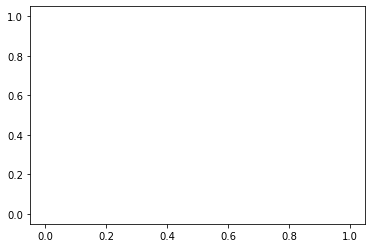

In [310]:
sns.distplot(celltype_rfam_pvalue_df['pvalue_adj'])

In [276]:
# infernal_celltypes[10].value_counts()

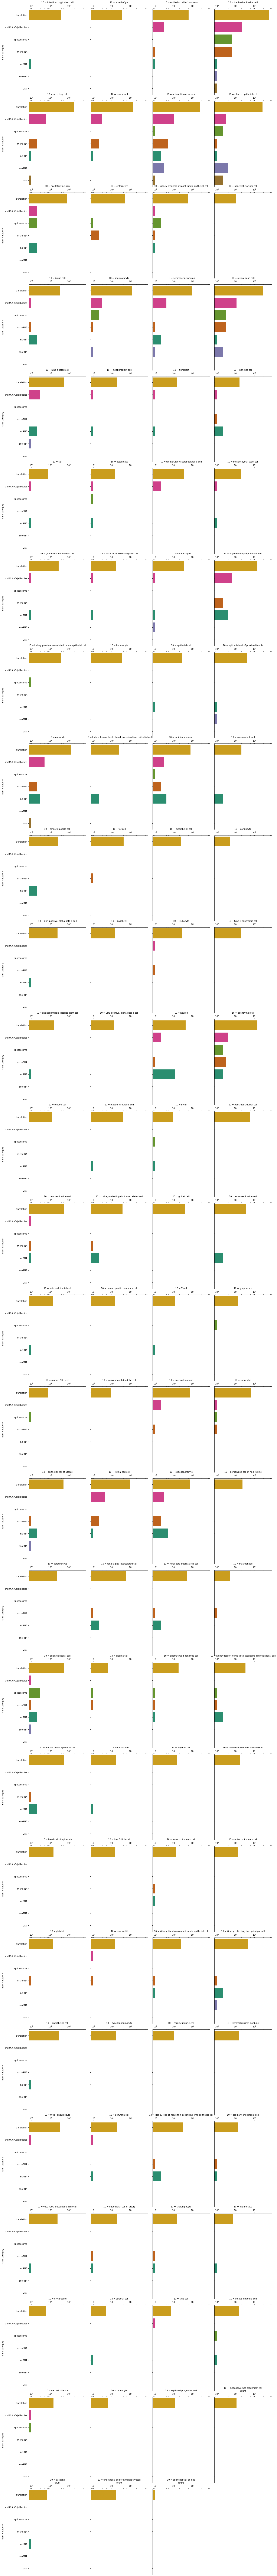

In [278]:
g = sns.catplot(data=infernal_celltypes, col=10, col_wrap=4,
                y='rfam_category', kind='count', height=3, aspect=1, 
                order=rfam_category_counts.index,
                palette=rfam_category_to_color,
                col_order=sorted(infernal_celltypes[10].unique())
#                 edgecolor='k',
#                 color='grey'
               )
g.set(xscale='log')
sns.despine(bottom=True, top=False)
g.set_titles("{col_var}")
for ax in g.axes.flat:
    ax.xaxis.set_label_position('top')

In [77]:
infernal_results_original.groupby('utar').apply(lambda x: x.nsmallest(5, 'e_value'))

target_name  \
utar                                                                                  
NC-033662.1-96455849-96456799-+-2430-0 0     A00111:71:H3TTFDMXX:1:2281:15365:36338   
                                       1     A00111:71:H3TTFDMXX:1:2281:15365:36338   
                                       3     A00111:71:H3TTFDMXX:1:2330:31376:25833   
                                       4      A00111:61:H3FYJDMXX:2:1287:2519:17127   
                                       5      A00111:61:H3FYJDMXX:2:1287:2519:17127   
NC-033663.1-17918799-17920049-+-5142-0 0      A00111:61:H3FYJDMXX:1:1147:9534:19382   
                                       1      A00111:61:H3FYJDMXX:1:1147:9534:19382   
                                       2    A00111:192:HFVL5DMXX:2:1158:28953:35258   
                                       3    A00111:192:HFVL5DMXX:2:1158:28953:35258   
                                       4      A00111:211:HGKCVDMXX:2:1348:8666:1438   
NC-033664.1-33565549-33566449---1802-0 0    A00111:192:HFVL5DMXX:2:2303:10384:18787   
                                       1    A00111:192:HFVL5DMXX:2:2303:10384:18787   
                                       2    A00111:192:HFVL5DMXX:2:2303:10384:18787   
                                       3     A00111:71:H3TTFDMXX:1:1457:30517:29575   
                                       4     A00111:71:H3TTFDMXX:1:1457:30517:29575   
NC-033669.1-13625749-13632399---2548-0 0       A00111:61:H3FYJDMXX:2:1337:8160:9330   
                                       29    A00111:71:H3TTFDMXX:1:1453:20745:15843   
                                       30    A00111:71:H3TTFDMXX:1:1453:20745:15843   
                                       106   A00111:212:HGMF5DMXX:2:2375:30264:6339   
                                       107   A00111:212:HGMF5DMXX:2:2375:30264:6339   
NC-033672.1-3091749-3092449---5590-0   0     A00111:192:HFVL5DMXX:1:2443:3775:29011   
                                       1     A00111:192:HFVL5DMXX:1:2443:3775:29011   
                                       2    A00111:192:HFVL5DMXX:1:2204:18412:36730   
                                       3    A00111:212:HGMF5DMXX:1:1121:19678:24267   
                                       4    A00111:212:HGMF5DMXX:1:1121:19678:24267   
NC-033674.1-7392049-7392949-+-19526-0  22   A00111:211:HGKCVDMXX:2:2272:30743:13463   
                                       23   A00111:211:HGKCVDMXX:2:2272:30743:13463   
                                       24   A00111:211:HGKCVDMXX:2:2272:30743:13463   
                                       25   A00111:211:HGKCVDMXX:2:2272:32588:12211   
                                       26   A00111:211:HGKCVDMXX:2:2272:32588:12211   
NC-033683.1-8262449-8264849---1542-0   0     A00111:71:H3TTFDMXX:2:1127:32226:13839   
                                       1     A00111:71:H3TTFDMXX:2:1127:32226:13839   
                                       2      A00111:61:H3FYJDMXX:1:1218:4426:26569   
                                       3      A00111:61:H3FYJDMXX:1:1218:4426:26569   
                                       4      A00111:61:H3FYJDMXX:1:2218:1823:26162   

                                           target_accession   query_name  \
utar                                                                       
NC-033662.1-96455849-96456799-+-2430-0 0                  -         tRNA   
                                       1                  -         tRNA   
                                       3                  -  Metazoa_SRP   
                                       4                  -  Metazoa_SRP   
                                       5                  -  Metazoa_SRP   
NC-033663.1-17918799-17920049-+-5142-0 0                  -           U2   
                                       1                  -           U2   
                                       2                  -           U2   
                                       3                  -           U2   
                

In [76]:
rfam2go.loc['RF00017']

,rfam_id_full,rfam_description,go_description,go_id
rfam_id,,,,
RF00017,Rfam:RF00017,Metazoa_SRP,"GO:signal recognition particle, endoplasmic re...",GO:0005786
RF00017,Rfam:RF00017,Metazoa_SRP,GO:SRP-dependent cotranslational protein targe...,GO:0006617


In [18]:
nucleotide_read_sizes_v2 = read_coding_noncoding_sizes('/mnt/data_sm/olga/tabula-microcebus/analyses/predictorthologs/utar-rerun-2020-05-22-v2/')
nucleotide_read_sizes_v2.head()

(19, 3)


,sample_id,noncoding_size,coding_size
0,NC-033660.1-32005049-32006349-+-257-0,3547244,0
1,NC-033660.1-59862949-59863849-+-4809-0,797393,20125
2,NC-033668.1-16834599-16834899---2359-0,363294,2994
3,NC-033668.1-9945349-9945849-+-7264-0,1317320,2199
4,NC-033664.1-8689199-8689499---228-0,12149448,1758


In [19]:
nucleotide_read_sizes_v1 = read_coding_noncoding_sizes('/mnt/data_sm/olga/tabula-microcebus/analyses/predictorthologs/utar-rerun-2020-05-22/')
nucleotide_read_sizes_v1.head()

(172, 3)


,sample_id,noncoding_size,coding_size
0,NC-033666.1-87751899-87752649---1795-0,1971,1900140
1,NC-033675.1-1535699-1537199-+-258-0,25388,7189297
2,NC-033666.1-99785849-99786449---362-0,507,7585246
3,NC-033677.1-22142349-22142749---2775-0,505,377782
4,NC-033660.1-27699899-27700849---304-0,808,9265737


In [20]:
set(nucleotide_read_sizes_v1.sample_id).intersection(nucleotide_read_sizes_v2.sample_id).intersection(nucleotide_read_sizes_v2_mammals.sample_id)

{'NC-033660.1-32005049-32006349-+-257-0',
 'NC-033660.1-59862949-59863849-+-4809-0',
 'NC-033662.1-4835999-4837249-+-767-0',
 'NC-033663.1-31558099-31559249-+-6175-0',
 'NC-033665.1-113316949-113317299---5530-0',
 'NC-033666.1-56315099-56316449-+-143-0',
 'NC-033666.1-84468799-84469999-+-2485-0',
 'NC-033666.1-99335749-99343099-+-4865-0',
 'NC-033668.1-16834599-16834899---2359-0',
 'NC-033668.1-9945349-9945849-+-7264-0',
 'NC-033670.1-17451599-17453099---1508-0',
 'NC-033670.1-2594199-2594799-+-6532-0',
 'NC-033674.1-69962499-69963149-+-41-0',
 'NC-033676.1-46682249-46683099-+-2424-0',
 'NC-033678.1-292599-293699---156-0',
 'NC-033678.1-298349-299549-+-219-0',
 'NC-033692.1-70617349-70618249-+-5320-0'}

In [21]:
nucleotide_read_sizes_v2_mammals.query('noncoding_size > coding_size')

,sample_id,noncoding_size,coding_size
0,NC-033665.1-74760899-74761099-+-11192-0,1001791,3631
1,NC-033664.1-33565549-33566449---1802-0,132313,0
2,NC-033692.1-76371699-76374099-+-1254-0,24327516,0
3,NW-017968532.1-117249-127599-+-6640-0,85018651,0
4,NC-033681.1-2814399-2815549---766-0,72514299,0
...,...,...,...
155,NC-033666.1-16147049-16147399-+-8293-0,30700317,0
156,NC-033690.1-23259899-23260199-+-549-0,622221,0
157,NC-033674.1-69574099-69575149-+-270-0,7571017,0
158,NC-033671.1-102185749-102190399---1224-0,244969,106


In [22]:
nucleotide_read_sizes_v2_mammals.nlargest(10, columns='noncoding_size')

,sample_id,noncoding_size,coding_size
16,NC-033669.1-97215549-97217949---11113-0,284930818,1220
5,NC-033676.1-39088599-39090999---5263-0,200775886,3933
53,NC-033683.1-561999-566749-+-2329-0,118206984,24801
44,NC-033677.1-22802349-22803949-+-2629-0,98570998,180
131,NC-033662.1-85154499-85155349-+-2155-0,89622020,0
3,NW-017968532.1-117249-127599-+-6640-0,85018651,0
4,NC-033681.1-2814399-2815549---766-0,72514299,0
66,NC-033683.1-1158549-1161599-+-1938-0,72040411,118
15,NC-033681.1-2812399-2812749---963-0,69593400,0
7,NC-033692.1-66595699-66596949---1522-0,69439727,25303


In [23]:
nucleotide_read_sizes_v2_mammals['noncoding_over_coding'] = nucleotide_read_sizes_v2_mammals.noncoding_size/nucleotide_read_sizes_v2_mammals.coding_size
nucleotide_read_sizes_v2_mammals.head()

,sample_id,noncoding_size,coding_size,noncoding_over_coding
0,NC-033665.1-74760899-74761099-+-11192-0,1001791,3631,275.899477
1,NC-033664.1-33565549-33566449---1802-0,132313,0,inf
2,NC-033692.1-76371699-76374099-+-1254-0,24327516,0,inf
3,NW-017968532.1-117249-127599-+-6640-0,85018651,0,inf
4,NC-033681.1-2814399-2815549---766-0,72514299,0,inf


In [24]:
nucleotide_read_sizes_v2_mammals.nlargest(10, columns='noncoding_over_coding')

,sample_id,noncoding_size,coding_size,noncoding_over_coding
1,NC-033664.1-33565549-33566449---1802-0,132313,0,inf
2,NC-033692.1-76371699-76374099-+-1254-0,24327516,0,inf
3,NW-017968532.1-117249-127599-+-6640-0,85018651,0,inf
4,NC-033681.1-2814399-2815549---766-0,72514299,0,inf
6,NC-033661.1-123438649-123439249---281-0,7401833,0,inf
9,NC-033685.1-21224799-21231149-+-3279-0,813523,0,inf
10,NC-033660.1-32005049-32006349-+-257-0,3538158,0,inf
15,NC-033681.1-2812399-2812749---963-0,69593400,0,inf
17,NC-033669.1-22599-25649-+-200-0,3693242,0,inf
18,NC-033667.1-151748949-151749499-+-37-0,866232,0,inf


In [25]:
nucleotide_read_sizes_v2_mammals.nsmallest(10, columns='noncoding_over_coding')

,sample_id,noncoding_size,coding_size,noncoding_over_coding
130,NC-033661.1-115849799-115852999-+-3677-0,6874046,12772981,0.538171
106,NC-033669.1-91222099-91223399-+-34382-0,1315781,78443,16.773721
90,NC-033674.1-55521199-55521499---919-0,622318,18455,33.720834
109,NC-033665.1-30863199-30863699-+-3046-0,673377,18065,37.275228
52,NC-033676.1-58897399-58897599---2079-0,1428763,28889,49.456991
20,NC-033686.1-5779999-5781149-+-77235-0,501585,7862,63.798652
154,NC-033669.1-76020049-76020399-+-7394-0,663240,10141,65.401834
75,NC-033667.1-136426249-136427849-+-1870-0,1686443,23670,71.248120
93,NC-033667.1-12538499-12539249---3289-0,361704,4749,76.164245
11,NC-033660.1-59862949-59863849-+-4809-0,795817,9758,81.555339


# Read DIAMOND Blastp output

In [77]:
outdir

'/mnt/ibm_sm/olga/tabula-microcebus/analyses/predictorthologs/utar-rerun-2020-05-22-rmdup-v2-mammals'

In [718]:
filenames = glob.iglob(f'{outdir}/diamond/blastp/*.tsv')

dfs = []

DIAMOND_BLASTP_COLUMNS = ['read_id', 'subject_id', 'percent_identity', 'e_value', 'bitscore', 
           'subject_title', 'subject_taxid', 'subject_species', 'subject_kingdom', 
           'subject_superkingdom',
           'subject_phylum']

def read_diamond_blastp_output(filename):
    df = pd.read_csv(filename, sep='\t', names=DIAMOND_BLASTP_COLUMNS)
    return df
    

n = 0

for filename in tqdm(filenames):
    filesize = os.path.getsize(filename)
    if filesize > 0:
        n += 1
        basename = os.path.basename(filename)
        split = basename.split('__')
        utar_id = split[0]
#         utar_id = split[1]
        
        df = read_diamond_blastp_output(filename)
        df['region_id'] = utar_id
#         df['cell_ontology_class'] = celltype
        dfs.append(df)

print(f'Number of utars with homology: {n}')
utar_homology = pd.concat(dfs)
print(utar_homology.shape)
utar_homology.head()

443it [00:03, 119.58it/s]


Number of utars with homology: 330
(16745, 12)


,read_id,subject_id,percent_identity,e_value,bitscore,subject_title,subject_taxid,subject_species,subject_kingdom,subject_superkingdom,subject_phylum,region_id
0,A00111:192:HFVL5DMXX:1:1424:28113:1204,NP_445906.1,100.0,2.500000e-09,59.7,NP_445906.1 nuclear receptor coactivator 3 [Ra...,10116,Rattus norvegicus,Eukaryota,Chordata,NaN,nc-033677.1-40999349-41003199-+-259-0
1,A00111:192:HFVL5DMXX:1:1424:28113:1204,NP_001361708.1,100.0,2.500000e-09,59.7,NP_001361708.1 nuclear receptor coactivator 3 ...,10090,Mus musculus,Eukaryota,Chordata,NaN,nc-033677.1-40999349-41003199-+-259-0
2,A00111:192:HFVL5DMXX:1:1424:28113:1204,NP_032705.2,100.0,2.500000e-09,59.7,NP_032705.2 nuclear receptor coactivator 3 iso...,10090,Mus musculus,Eukaryota,Chordata,NaN,nc-033677.1-40999349-41003199-+-259-0
0,A00111:212:HGMF5DMXX:1:2345:26729:19194,NP_001267090.1,100.0,3.000000e-07,52.8,NP_001267090.1 T-complex protein 1 subunit del...,9598,Pan troglodytes,Eukaryota,Chordata,NaN,nc-033661.1-6618949-6620399-+-1238-0
1,A00111:212:HGMF5DMXX:1:2345:26729:19194,NP_001126621.1,100.0,3.000000e-07,52.8,NP_001126621.1 T-complex protein 1 subunit del...,9601,Pongo abelii,Eukaryota,Chordata,NaN,nc-033661.1-6618949-6620399-+-1238-0


In [719]:
split

['nc-033662.1-109292499-109295499---288-0',
 'diamond',
 'vertebrate_mammalian_concatenated',
 'np_only_db.tsv']

## Extract gene predictions

In [720]:
pattern = '\d+.\d(.+)\[[\w ]+\]'
utar_homology.subject_title.head().str.extract(pattern)

,0
0,nuclear receptor coactivator 3
1,nuclear receptor coactivator 3 isoform 2
2,nuclear receptor coactivator 3 isoform 1
0,T-complex protein 1 subunit delta
1,T-complex protein 1 subunit delta


In [721]:
utar_homology['subject_description_with_predicted'] = utar_homology.subject_title.str.extract(pattern)
utar_homology['is_predicted'] = utar_homology.subject_title.str.contains('PREDICTED')
utar_homology['subject_description'] = utar_homology.subject_description_with_predicted.str.split('PREDICTED: ').str[-1]
utar_homology.head()

,read_id,subject_id,percent_identity,e_value,bitscore,subject_title,subject_taxid,subject_species,subject_kingdom,subject_superkingdom,subject_phylum,region_id,subject_description_with_predicted,is_predicted,subject_description
0,A00111:192:HFVL5DMXX:1:1424:28113:1204,NP_445906.1,100.0,2.500000e-09,59.7,NP_445906.1 nuclear receptor coactivator 3 [Ra...,10116,Rattus norvegicus,Eukaryota,Chordata,NaN,nc-033677.1-40999349-41003199-+-259-0,nuclear receptor coactivator 3,False,nuclear receptor coactivator 3
1,A00111:192:HFVL5DMXX:1:1424:28113:1204,NP_001361708.1,100.0,2.500000e-09,59.7,NP_001361708.1 nuclear receptor coactivator 3 ...,10090,Mus musculus,Eukaryota,Chordata,NaN,nc-033677.1-40999349-41003199-+-259-0,nuclear receptor coactivator 3 isoform 2,False,nuclear receptor coactivator 3 isoform 2
2,A00111:192:HFVL5DMXX:1:1424:28113:1204,NP_032705.2,100.0,2.500000e-09,59.7,NP_032705.2 nuclear receptor coactivator 3 iso...,10090,Mus musculus,Eukaryota,Chordata,NaN,nc-033677.1-40999349-41003199-+-259-0,nuclear receptor coactivator 3 isoform 1,False,nuclear receptor coactivator 3 isoform 1
0,A00111:212:HGMF5DMXX:1:2345:26729:19194,NP_001267090.1,100.0,3.000000e-07,52.8,NP_001267090.1 T-complex protein 1 subunit del...,9598,Pan troglodytes,Eukaryota,Chordata,NaN,nc-033661.1-6618949-6620399-+-1238-0,T-complex protein 1 subunit delta,False,T-complex protein 1 subunit delta
1,A00111:212:HGMF5DMXX:1:2345:26729:19194,NP_001126621.1,100.0,3.000000e-07,52.8,NP_001126621.1 T-complex protein 1 subunit del...,9601,Pongo abelii,Eukaryota,Chordata,NaN,nc-033661.1-6618949-6620399-+-1238-0,T-complex protein 1 subunit delta,False,T-complex protein 1 subunit delta


In [722]:
utar_homology.groupby('region_id').apply(lambda x: x.subject_description.value_counts().head()).to_frame()

subject_description
region_id                                                                                                        
nc-033660.1-103044949-103045399---164-0    60S ribosomal protein L32                                           60
nc-033660.1-111179549-111184949---155-0    protein TFG                                                          3
nc-033660.1-27168399-27168999---15612-0    60S ribosomal protein L37a                                         141
nc-033660.1-38015249-38018599-+-1235-0     neprilysin                                                           3
nc-033660.1-44911399-44911899---601-0      histone deacetylase 2                                                3
nc-033660.1-631599-634849-+-101-0          rhomboid domain-containing protein 3                                42
nc-033660.1-77001649-77003449---157-0      eukaryotic translation initiation factor 4 gam...                    1
                                           eukaryotic translation initiation factor 4 gam...                    1
                                           eukaryotic translation initiation factor 4 gam...                    1
nc-033660.1-87624599-87626899---848-0      60S ribosomal protein L12                                          195
nc-033661.1-101121299-101121499---3497-0   translocon-associated protein subunit delta pr...                   70
                                           translocon-associated protein subunit delta is...                   21
                                           translocon-associated protein subunit delta is...                   16
                                           translocon-associated protein subunit delta is...                   16
nc-033661.1-104973499-104974849---109-0    proteasome subunit alpha type-5 isoform 2                            2
                                           proteasome subunit alpha type-5                                      1
nc-033661.1-109606299-109611949-+-384-0    heterochromatin protein 1-binding protein 3                         35
                                           heterochromatin protein 1-binding protein 3 is...                   27
                                           heterochromatin protein 1-binding protein 3 is...                   16
                                           heterochromatin protein 1-binding protein 3 is...                   14
                                           heterochromatin protein 1-binding protein 3 is...                    8
nc-033661.1-109771699-109773599-+-90-0     DNA-directed RNA polymerase III subunit RPC7-l...                    1
                                           DNA-directed RNA polymerase III subunit RPC7-l...                    1
                                           DNA-directed RNA polymerase III subunit RPC7-l...                    1
nc-033661.1-115490999-115493999---112-0    high affinity immunoglobulin epsilon receptor ...                    3
nc-033661.1-115656149-115656449-+-456-0    intelectin-2 precursor                                               6
                                           high affinity immunoglobulin epsilon receptor ...                    3
                                           intelectin-1 precursor                                               3
nc-033661.1-115690099-115693899-+-3680-0   intelectin-2 precursor                                               6
                                           high affinity immunoglobulin epsilon receptor ...                    3
                                           intelectin-1 precursor                                               3
nc-033661.1-115849799-115852999-+-3677-0   DCN1-like protein 1                                                440
                                           DCN1-like protein 1 isoform 2                                      411
                                           DCN1-like protein 1 isoform 1                                

## Add inverse e-value

In [155]:
utar_homology['e_value_inverse'] = 1/utar_homology['e_value']

## Write utar protein predictions to file

In [742]:


def write_tables(df, prefix, formats=('csv', 'parquet')):
    for fmt in formats:
        filename = f'{prefix}.{fmt}'
        if fmt == 'csv':
            df.to_csv(filename)
        if fmt == 'parquet':
            df.to_parquet(filename)
        

write_tables(utar_homology, '/home/olga/data_sm/tabula-microcebus/analyses/de-novo-orthology/uTAR/utar_predictions__protein_per_read')

## Predict most likely annotation using weighted averages

In [379]:
utar_homology_predictions = utar_homology.groupby('region_id').apply(lambda x: most_likely_sequence(x, id_col='subject_description', weight_col='e_value_inverse'))
utar_homology_predictions.index = utar_homology_predictions.index.str.upper()
print(utar_homology_predictions.shape)
utar_homology_predictions.head()

(330, 2)


,subject_description,e_value_inverse__weighted
region_id,,
NC-033660.1-103044949-103045399---164-0,60S ribosomal protein L32,7.629546e+11
NC-033660.1-111179549-111184949---155-0,protein TFG,3.157895e+08
NC-033660.1-27168399-27168999---15612-0,60S ribosomal protein L37a,5.310386e+13
NC-033660.1-38015249-38018599-+-1235-0,neprilysin,3.000000e+10
NC-033660.1-44911399-44911899---601-0,histone deacetylase 2,2.500000e+08


In [382]:
utar_homology_predictions.loc[~utar_homology_predictions['subject_description'].str.contains('ribosom'), 'subject_description'].value_counts()

 catenin alpha-2                                                                             6
 5,6-dihydroxyindole-2-carboxylic acid oxidase precursor                                     4
 E3 ubiquitin-protein ligase RNF130 isoform 1 precursor                                      4
 1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase beta-2                            4
 pancreatic progenitor cell differentiation and proliferation factor                         3
 DNA-directed RNA polymerases I, II, and III subunit RPABC2                                  3
 dipeptidyl aminopeptidase-like protein 6 isoform 2                                          3
 serine/threonine-protein phosphatase 4 catalytic subunit                                    3
 copper transport protein ATOX1                                                              3
 retinol dehydrogenase 16                                                                    2
 DNA-directed RNA polymerase I subunit RPA12      

In [383]:
csv_outdir = '/home/olga/googledrive/TabulaMicrocebus/analysis/utar-predictorthologs'
utar_homology_predictions.to_csv(f'{csv_outdir}/protein_coding_diamond_blastp_top_predictions.csv')

In [384]:
csv_outdir = '/home/olga/googledrive/TabulaMicrocebus/analysis/utar-predictorthologs'
utar_homology.to_csv(f'{csv_outdir}/protein_coding_diamond_blastp_full_results.csv')

In [385]:
utar_homology_predictions.subject_description.value_counts()

 catenin alpha-2                                                                             6
 E3 ubiquitin-protein ligase RNF130 isoform 1 precursor                                      4
 1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase beta-2                            4
 40S ribosomal protein S4, X isoform                                                         4
 5,6-dihydroxyindole-2-carboxylic acid oxidase precursor                                     4
 copper transport protein ATOX1                                                              3
 60S ribosomal protein L36                                                                   3
 dipeptidyl aminopeptidase-like protein 6 isoform 2                                          3
 DNA-directed RNA polymerases I, II, and III subunit RPABC2                                  3
 serine/threonine-protein phosphatase 4 catalytic subunit                                    3
 pancreatic progenitor cell differentiation and pr

## Count most common words in descriptions

In [406]:
words = chain(*[x.split() for x in utar_homology_predictions.subject_description.unique()])
protein_description_word_counts = pd.Series(Counter(words))
print(protein_description_word_counts.shape)
protein_description_word_counts = protein_description_word_counts.sort_values(ascending=False)
protein_description_word_counts[protein_description_word_counts > 5]

(505,)


protein              116
1                     55
isoform               41
subunit               39
ribosomal             38
precursor             27
2                     25
factor                22
60S                   20
mitochondrial         14
domain-containing     14
3                     13
40S                   12
homolog               11
nuclear                9
beta                   8
receptor               8
ribonucleoprotein      8
cytochrome             7
and                    7
4                      7
oxidase                7
proteasome             6
a                      6
member                 6
dtype: int64

### Are these groups overlapping?

In [685]:
utar_homology_predictions.head()

,subject_description,e_value_inverse__weighted,category_manual,dark_color
region_id,,,,
NC-033660.1-103044949-103045399---164-0,60S ribosomal protein L32,7.629546e+11,ribosomal,#beaed4
NC-033660.1-111179549-111184949---155-0,protein TFG,3.157895e+08,other,#7fc97f
NC-033660.1-27168399-27168999---15612-0,60S ribosomal protein L37a,5.310386e+13,ribosomal,#beaed4
NC-033660.1-38015249-38018599-+-1235-0,neprilysin,3.000000e+10,other,#7fc97f
NC-033660.1-44911399-44911899---601-0,histone deacetylase 2,2.500000e+08,other,#7fc97f


In [643]:
words = 'ribosomal', 'mitochondrial', 'receptor', 'ribonucleoprotein', 'protease', 'nuclear'

df = pd.DataFrame(index=utar_homology_predictions.index)

for word in words:
    df[word] = utar_homology_predictions.subject_description.str.contains(word)
df.head()

,ribosomal,mitochondrial,receptor,ribonucleoprotein,protease,nuclear
region_id,,,,,,
NC-033660.1-103044949-103045399---164-0,True,False,False,False,False,False
NC-033660.1-111179549-111184949---155-0,False,False,False,False,False,False
NC-033660.1-27168399-27168999---15612-0,True,False,False,False,False,False
NC-033660.1-38015249-38018599-+-1235-0,False,False,False,False,False,False
NC-033660.1-44911399-44911899---601-0,False,False,False,False,False,False


In [645]:
(df.sum(axis=1) > 1).sum()

10

In [646]:
df.loc[df.sum(axis=1) > 1]

,ribosomal,mitochondrial,receptor,ribonucleoprotein,protease,nuclear
region_id,,,,,,
NC-033664.1-10320349-10329999-+-32787-0,True,True,False,False,False,False
NC-033665.1-77406999-77407749-+-4999-0,True,True,False,False,False,False
NC-033671.1-49300899-49304849---1921-0,False,False,False,True,False,True
NC-033673.1-27053849-27054349---238-0,False,False,False,True,False,True
NC-033674.1-36113449-36113549-+-348-0,False,False,False,True,False,True
NC-033677.1-40999349-41003199-+-259-0,False,False,True,False,False,True
NC-033677.1-41046699-41050799-+-65-0,False,False,True,False,False,True
NC-033678.1-78952449-78958499-+-2203-0,False,False,False,True,False,True
NC-033681.1-17673899-17677199-+-228-0,False,False,False,True,False,True


In [678]:
# Take *first* match
words_ordered = 'nuclear', 'receptor', 'protease', 'mitochondrial', \
    'ribosomal', 'catenin'

def add_protein_category(subject_description):
    matches = [word for word in words_ordered if word in subject_description]
    if matches:
        return matches[0]
    else:
        return 'other'
    

utar_homology_predictions['category_manual'] = utar_homology_predictions.subject_description.map(add_protein_category)
protein_category_counts = utar_homology_predictions['category_manual'].value_counts()
protein_category_counts

other            245
ribosomal         47
mitochondrial     14
nuclear           10
receptor           8
catenin            6
Name: category_manual, dtype: int64

In [679]:
utar_homology_predictions.query('category_manual == "other"').head()

,subject_description,e_value_inverse__weighted,category_manual,dark_color
region_id,,,,
NC-033660.1-111179549-111184949---155-0,protein TFG,3.157895e+08,other,#7fc97f
NC-033660.1-38015249-38018599-+-1235-0,neprilysin,3.000000e+10,other,#7fc97f
NC-033660.1-44911399-44911899---601-0,histone deacetylase 2,2.500000e+08,other,#7fc97f
NC-033660.1-631599-634849-+-101-0,rhomboid domain-containing protein 3,5.232788e+08,other,#7fc97f
NC-033660.1-77001649-77003449---157-0,eukaryotic translation initiation factor 4 ga...,1.250000e+10,other,#666666


## Plot protein-coding distribution

### Assign repbase/repeatmasker colors

In [680]:
palette = [rgb2hex(x) for x in sns.color_palette("Accent", n_colors=len(protein_category_counts))]
protein_category_to_color = dict(zip(protein_category_counts.index, palette))
utar_homology_predictions['dark_color'] = utar_homology_predictions['category_manual'].map(protein_category_to_color)

utar_homology_predictions.head()

,subject_description,e_value_inverse__weighted,category_manual,dark_color
region_id,,,,
NC-033660.1-103044949-103045399---164-0,60S ribosomal protein L32,7.629546e+11,ribosomal,#beaed4
NC-033660.1-111179549-111184949---155-0,protein TFG,3.157895e+08,other,#7fc97f
NC-033660.1-27168399-27168999---15612-0,60S ribosomal protein L37a,5.310386e+13,ribosomal,#beaed4
NC-033660.1-38015249-38018599-+-1235-0,neprilysin,3.000000e+10,other,#7fc97f
NC-033660.1-44911399-44911899---601-0,histone deacetylase 2,2.500000e+08,other,#7fc97f


## Plot coding and non-coding overlapping in same figure

### DNA element type

In [681]:
# dark_palette

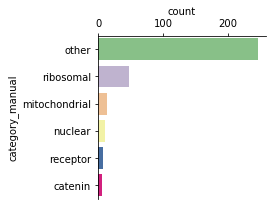

In [683]:
def barplot(df, y, color, order):

    palette = dict(zip(df[y].values, df[color]))

    sns.countplot(y=y, data=df, palette=palette, order=order)

    sns.despine(bottom=True, top=False)
    ax.xaxis.set_label_position('top')
    
fig, ax = plt.subplots(figsize=(3, 3))
barplot(utar_homology_predictions, 'category_manual', 'dark_color', protein_category_counts.index)

([<matplotlib.patches.Wedge at 0x7f817fbd1128>,
 [Text(-0.7590869306998888, 0.7961074246862809, 'other'),
  Text(0.4281971574827855, -1.0132360012966686, 'ribosomal'),
  Text(0.9138887085685405, -0.612215181411671, 'mitochondrial'),
  Text(1.0288032542031798, -0.38931203955304, 'nuclear'),
  Text(1.0801215755531504, -0.20817632436129802, 'receptor'),
  Text(1.0982060166371597, -0.06279765140467079, 'catenin')])

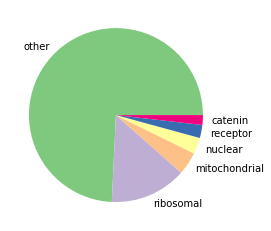

In [684]:
pie_data = utar_homology_predictions['category_manual'].value_counts()
plt.pie(pie_data, colors=palette, labels=pie_data.index)

# Plot distribution of coding/noncoding

In [386]:
infernal_celltypes.shape

(5435, 20)

In [387]:
N_TOTAL_UTARS = 1970

In [388]:
print(infernal_results_original_good_evalue_likely_rnas_no_go.shape)
infernal_results_original_good_evalue_likely_rnas_no_go.head()

(1937, 5)


,query_accession,e_value_inverse__weighted,rfam_id_full,rfam_description,rfam_category
utar,,,,,
NC-033660.1-100839949-100841299---38-0,RF00017,5.659683e+09,Rfam:RF00017,Metazoa_SRP,translation
NC-033660.1-101997299-101998899-+-1244-0,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,translation
NC-033660.1-103044949-103045399---164-0,RF00015,1.187797e+17,Rfam:RF00015,U4,spliceosome
NC-033660.1-1031849-1032749---576-0,RF00017,8.580173e+09,Rfam:RF00017,Metazoa_SRP,translation
NC-033660.1-103461149-103463199---710-0,RF00017,8.862436e+12,Rfam:RF00017,Metazoa_SRP,translation


In [390]:
utar_homology_predictions.shape

(330, 2)

In [391]:
index = utar_homology_predictions.index.difference(infernal_results_original_good_evalue_likely_rnas_no_go.index)
utar_homology_predictions.loc[index]

,subject_description,e_value_inverse__weighted
NC-033689.1-12202249-12208399-+-821-0,phospholipid-transporting ATPase IA,1.402730e+11
NW-017969113.1-2149-3199-+-2619-0,40S ribosomal protein S3,6.370821e+11


In [389]:
infernal_results_original_good_evalue_likely_rnas_no_go.index.isin(utar_homology_predictions.index).sum()

328

## Venn diagram of coding vs noncoding

In [392]:
from matplotlib_venn import venn2

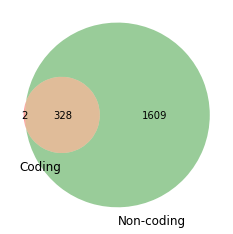

In [395]:
coding_set = set(utar_homology_predictions.index)
noncoding_set = set(infernal_results_original_good_evalue_likely_rnas_no_go.index)
venn2([coding_set, noncoding_set], set_labels=['Coding', 'Non-coding'])

## What are the noncoding sequences that show up in the coding regions?

In [408]:
index = infernal_results_original_good_evalue_likely_rnas_no_go.index.intersection(utar_homology_predictions.index)
noncoding_in_coding = infernal_results_original_good_evalue_likely_rnas_no_go.loc[index]
noncoding_in_coding.head()

,query_accession,e_value_inverse__weighted,rfam_id_full,rfam_description,rfam_category
NC-033660.1-103044949-103045399---164-0,RF00015,1.187797e+17,Rfam:RF00015,U4,spliceosome
NC-033660.1-111179549-111184949---155-0,RF00017,9.251864e+07,Rfam:RF00017,Metazoa_SRP,translation
NC-033660.1-27168399-27168999---15612-0,RF00017,1.966519e+11,Rfam:RF00017,Metazoa_SRP,translation
NC-033660.1-38015249-38018599-+-1235-0,RF00017,4.344808e+11,Rfam:RF00017,Metazoa_SRP,translation
NC-033660.1-44911399-44911899---601-0,RF00017,6.572014e+09,Rfam:RF00017,Metazoa_SRP,translation


### Count of noncoding RNA elements in coding regions Barplot

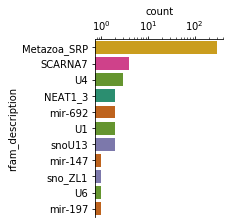

In [426]:
plot_rfam_counts(noncoding_in_coding, height=3, aspect=1.1)

### Count of noncoding RNA elements in coding regions Barplot - by category

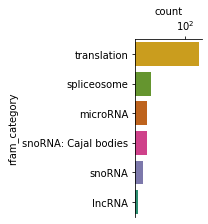

In [422]:
plot_rfam_counts(noncoding_in_coding, y='rfam_category', height=3, aspect=1)

### Plot in same order as original

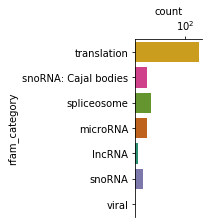

In [430]:
rfam_category_order = infernal_results_original_good_evalue_likely_rnas_no_go.rfam_category.value_counts()
plot_rfam_counts(noncoding_in_coding, y='rfam_category', height=3, aspect=1, order=rfam_category_order)

## What are the noncoding sequences that are ONLY found in the noncoding uTARs?

In [427]:
index = infernal_results_original_good_evalue_likely_rnas_no_go.index.difference(utar_homology_predictions.index)
totally_noncoding = infernal_results_original_good_evalue_likely_rnas_no_go.loc[index]
totally_noncoding.head()

,query_accession,e_value_inverse__weighted,rfam_id_full,rfam_description,rfam_category
NC-033660.1-100839949-100841299---38-0,RF00017,5.659683e+09,Rfam:RF00017,Metazoa_SRP,translation
NC-033660.1-101997299-101998899-+-1244-0,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,translation
NC-033660.1-1031849-1032749---576-0,RF00017,8.580173e+09,Rfam:RF00017,Metazoa_SRP,translation
NC-033660.1-103461149-103463199---710-0,RF00017,8.862436e+12,Rfam:RF00017,Metazoa_SRP,translation
NC-033660.1-103464149-103465799---109-0,RF00017,8.607996e+12,Rfam:RF00017,Metazoa_SRP,translation


### Count of noncoding RNA elements in coding regions Barplot

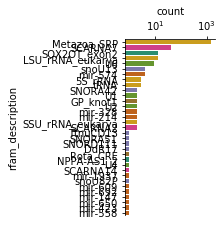

In [428]:
plot_rfam_counts(totally_noncoding, height=3, aspect=1.1)

### Count of noncoding RNA elements in coding regions Barplot - by category

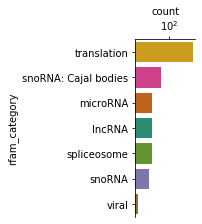

In [429]:
plot_rfam_counts(totally_noncoding, y='rfam_category', height=3, aspect=1)

### Plot in same order as original

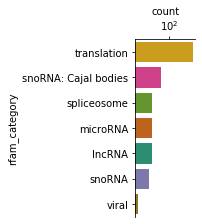

In [431]:
rfam_category_order = infernal_results_original_good_evalue_likely_rnas_no_go.rfam_category.value_counts()
plot_rfam_counts(totally_noncoding, y='rfam_category', height=3, aspect=1, order=rfam_category_order)

## Plot coding and non-coding overlapping in same figure

### Rfam description

In [450]:

def tidify_join(counts, col, noncoding):
    rfam_counts_df = counts.to_frame()
    rfam_counts_df['n_coding'] = noncoding[col].value_counts()
    rfam_counts_df = rfam_counts_df.reset_index()
    rfam_counts_df = rfam_counts_df.rename(columns={col: 'n_total', 'index': col})
    print(rfam_counts_df.shape)
    return rfam_counts_df

rfam_counts_df = tidify_join(rfam_counts, 'rfam_description', noncoding_in_coding)
rfam_counts_df.head()

(36, 3)


,rfam_description,n_total,n_coding
0,Metazoa_SRP,1772,305.0
1,SCARNA7,44,4.0
2,SOX2OT_exon2,13,NaN
3,LSU_rRNA_eukarya,13,NaN
4,U6,10,1.0


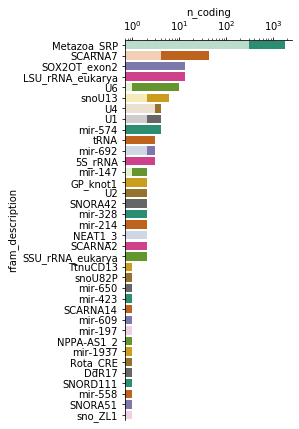

In [451]:
fig, ax = plt.subplots(figsize=(3, 7))
sns.barplot('n_total', 'rfam_description', data=rfam_counts_df, palette='Dark2')
sns.barplot('n_coding', 'rfam_description', data=rfam_counts_df, palette='Pastel2')
ax.set(xscale='log')
sns.despine(bottom=True, top=False)
ax.xaxis.set_label_position('top')

### Rfam category

In [454]:
col = 'rfam_category'

rfam_category_counts_df = tidify_join(rfam_category_counts, col, noncoding_in_coding)
rfam_category_counts_df.head()

(7, 3)


,rfam_category,n_total,n_coding
0,translation,1793,305.0
1,snoRNA: Cajal bodies,47,4.0
2,spliceosome,20,6.0
3,microRNA,19,4.0
4,lncRNA,16,2.0


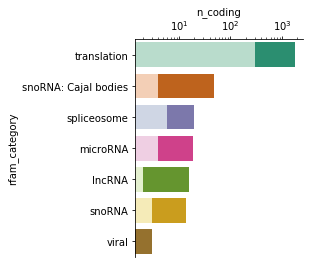

In [458]:
fig, ax = plt.subplots(figsize=(3, 4))
sns.barplot('n_total', col, data=rfam_category_counts_df, palette='Dark2')
sns.barplot('n_coding', col, data=rfam_category_counts_df, palette='Pastel2')
ax.set(xscale='log')
sns.despine(bottom=True, top=False)
ax.xaxis.set_label_position('top')

# Bedtools intersect with repeatmasker

In [172]:
utar_dir = '/home/olga/data_sm/tabula-microcebus/analyses/de-novo-orthology/uTAR/'
chromosome_to_accession = pd.read_csv(f'{utar_dir}/chr2acc', sep='\t')
print(chromosome_to_accession.shape)
chromosome_to_accession.head()

(33, 2)


,#Chromosome,Accession.version
0,1,NC_033660.1
1,2,NC_033661.1
2,3,NC_033662.1
3,4,NC_033663.1
4,5,NC_033664.1


In [174]:
utar_bed = pd.read_csv(f'{utar_dir}/cellTypeMarkersUTarsPeaks_deduplicated.bed', sep='\t', header=None)
print(utar_bed.shape)
utar_bed.head()

(1970, 6)


,0,1,2,3,4,5
0,NW_017968608.1,2815,2898,NW-017968608.1-2349-3349---197360-0,.,-
1,NC_033669.1,97217022,97217242,NC-033669.1-97215549-97217949---11113-0,.,-
2,NC_033666.1,16147071,16147137,NC-033666.1-16147049-16147399-+-8293-0,.,+
3,NC_033662.1,92200223,92200573,NC-033662.1-92197399-92201049-+-14496-0,.,+
4,NC_033662.1,2176702,2176806,NC-033662.1-2176549-2177049---10702-0,.,-


In [175]:
utar_unique_chroms = set(utar_bed[0])
len(utar_unique_chroms)

44

In [176]:
utar_unique_chroms.difference(chromosome_to_accession['Accession.version'])

{'NW_017968519.1',
 'NW_017968520.1',
 'NW_017968521.1',
 'NW_017968522.1',
 'NW_017968523.1',
 'NW_017968524.1',
 'NW_017968525.1',
 'NW_017968532.1',
 'NW_017968535.1',
 'NW_017968608.1',
 'NW_017969113.1'}

In [177]:
repeatmasker_bed = pd.read_csv(f'{utar_dir}/micMur3_repeatMasker.bed', sep='\t', header=None)
print(repeatmasker_bed.shape)
repeatmasker_bed.head()

(4032013, 6)


,0,1,2,3,4,5
0,chr1,33554360,33554479,Charlie2a,683,-
1,chr1,41942950,41943260,L1M5,451,+
2,chr1,58718791,58721263,MER34B-int,3792,+
3,chr1,75497004,75497541,LTR24B,2924,-
4,chr1,100662131,100663753,L1MA5,2895,+


In [180]:
repeatmasker_bed.tail()

,0,1,2,3,4,5
4032008,chr31_NW_017968298v1_random,348,760,LTR41,1734,-
4032009,chr31_NW_017968298v1_random,1052,1174,MER31B,440,+
4032010,chr31_NW_017968299v1_random,566,591,(TTAT)n,13,+
4032011,chr31_NW_017968299v1_random,1082,1116,(TA)n,16,+
4032012,chr31_NW_017968300v1_random,682,737,(AAC)n,15,+


In [191]:
repeatmasker_bed['nw_accession'] = repeatmasker_bed[0].str.extract('(NW_\d+v\d)')
repeatmasker_bed.head()

,0,1,2,3,4,5,nw_accession
0,chr1,33554360,33554479,Charlie2a,683,-,NaN
1,chr1,41942950,41943260,L1M5,451,+,NaN
2,chr1,58718791,58721263,MER34B-int,3792,+,NaN
3,chr1,75497004,75497541,LTR24B,2924,-,NaN
4,chr1,100662131,100663753,L1MA5,2895,+,NaN


In [193]:
repeatmasker_accessions = set(repeatmasker_bed['nw_accession'].dropna().unique())
len(repeatmasker_accessions)

7436

In [178]:
repeatmasker_chroms = set(repeatmasker_bed[0])
len(repeatmasker_chroms)

7470

In [179]:
len(repeatmasker_chroms.intersection(utar_unique_chroms))

0

In [187]:
scaffold_to_accession = pd.read_csv(f'{utar_dir}/scaffold_localID2acc', sep='\t')
scaffold_to_accession['accession_version'] = scaffold_to_accession['Accession.version'].str.replace(r'.', 'v')
print(scaffold_to_accession.shape)
scaffold_to_accession.head()

(7677, 3)


,#Scaffold ID,Accession.version,accession_version
0,Chromosome1,NW_017963755.1,NW_017963755v1
1,Chromosome2,NW_017963756.1,NW_017963756v1
2,Chromosome3,NW_017963757.1,NW_017963757v1
3,Chromosome4,NW_017963758.1,NW_017963758v1
4,Chromosome5,NW_017963759.1,NW_017963759v1


In [196]:
rows = scaffold_to_accession['Accession.version'].isin(utar_unique_chroms)
scaffold_to_accession_in_utars = scaffold_to_accession.loc[rows]
print(scaffold_to_accession_in_utars.shape)
scaffold_to_accession_in_utars

(11, 3)


,#Scaffold ID,Accession.version,accession_version
4764,Scaffold1,NW_017968519.1,NW_017968519v1
4765,Scaffold2,NW_017968520.1,NW_017968520v1
4766,Scaffold3,NW_017968521.1,NW_017968521v1
4767,Scaffold4,NW_017968522.1,NW_017968522v1
4768,Scaffold5,NW_017968523.1,NW_017968523v1
4769,Scaffold6,NW_017968524.1,NW_017968524v1
4770,Scaffold7,NW_017968525.1,NW_017968525v1
4777,Scaffold14,NW_017968532.1,NW_017968532v1
4780,Scaffold17,NW_017968535.1,NW_017968535v1
4853,Scaffold90,NW_017968608.1,NW_017968608v1


In [203]:


rows = repeatmasker_bed['nw_accession'].isin(scaffold_to_accession_in_utars['accession_version'])
repeatmasker_bed_in_utars = repeatmasker_bed.loc[rows]
repeatmasker_bed_in_utars = repeatmasker_bed_in_utars.drop_duplicates('nw_accession')
repeatmasker_bed_in_utars = repeatmasker_bed_in_utars.set_index('nw_accession')
repeatmasker_bed_in_utars

,0,1,2,3,4,5
nw_accession,,,,,,
NW_017968519v1,chrUn_NW_017968519v1,131065,131102,(GT)n,43,+
NW_017968520v1,chrUn_NW_017968520v1,1048549,1048587,A-rich,15,+
NW_017968521v1,chrUn_NW_017968521v1,1048463,1048619,L2c,255,-
NW_017968522v1,chrUn_NW_017968522v1,129470,132889,L1B_Mim,23689,+
NW_017968523v1,chrUn_NW_017968523v1,393136,393492,Zaphod,794,+
NW_017968524v1,chrUn_NW_017968524v1,524251,524456,A-rich,63,+
NW_017968525v1,chrUn_NW_017968525v1,523999,524373,AluJ_Mim,1167,-
NW_017968532v1,chrUn_NW_017968532v1,131030,131281,LTR21_Mim,605,-
NW_017968535v1,chrUn_NW_017968535v1,0,101,LTR14B_Mim,506,+


In [206]:
scaffold_to_accession_in_utars.head()

,#Scaffold ID,Accession.version,accession_version
4764,Scaffold1,NW_017968519.1,NW_017968519v1
4765,Scaffold2,NW_017968520.1,NW_017968520v1
4766,Scaffold3,NW_017968521.1,NW_017968521v1
4767,Scaffold4,NW_017968522.1,NW_017968522v1
4768,Scaffold5,NW_017968523.1,NW_017968523v1


In [211]:
repeatmasker_bed_in_utars.loc[scaffold_to_accession_in_utars['accession_version'], 0]

nw_accession
NW_017968519v1    chrUn_NW_017968519v1
NW_017968520v1    chrUn_NW_017968520v1
NW_017968521v1    chrUn_NW_017968521v1
NW_017968522v1    chrUn_NW_017968522v1
NW_017968523v1    chrUn_NW_017968523v1
NW_017968524v1    chrUn_NW_017968524v1
NW_017968525v1    chrUn_NW_017968525v1
NW_017968532v1    chrUn_NW_017968532v1
NW_017968535v1    chrUn_NW_017968535v1
NW_017968608v1    chrUn_NW_017968608v1
NW_017969113v1    chrUn_NW_017969113v1
Name: 0, dtype: object

In [213]:
scaffold_to_accession_in_utars['ucsc_chrom'] = \
    repeatmasker_bed_in_utars.loc[scaffold_to_accession_in_utars['accession_version'], 0].values
scaffold_to_accession_in_utars.head()

/home/olga/miniconda3/envs/tabula-microcebus-v2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,#Scaffold ID,Accession.version,accession_version,ucsc_chrom
4764,Scaffold1,NW_017968519.1,NW_017968519v1,chrUn_NW_017968519v1
4765,Scaffold2,NW_017968520.1,NW_017968520v1,chrUn_NW_017968520v1
4766,Scaffold3,NW_017968521.1,NW_017968521v1,chrUn_NW_017968521v1
4767,Scaffold4,NW_017968522.1,NW_017968522v1,chrUn_NW_017968522v1
4768,Scaffold5,NW_017968523.1,NW_017968523v1,chrUn_NW_017968523v1


In [214]:
chromosome_to_accession.head()

,#Chromosome,Accession.version
0,1,NC_033660.1
1,2,NC_033661.1
2,3,NC_033662.1
3,4,NC_033663.1
4,5,NC_033664.1


In [216]:
chromosome_to_accession['ucsc_chrom'] = 'chr' + chromosome_to_accession['#Chromosome'].astype(str)
chromosome_to_accession.tail()

,#Chromosome,Accession.version,ucsc_chrom
28,29,NC_033688.1,chr29
29,30,NC_033689.1,chr30
30,31,NC_033690.1,chr31
31,32,NC_033691.1,chr32
32,X,NC_033692.1,chrX


## Make mapping of NCBI to ucsc chromosome names

In [217]:
ncbi_to_ucsc_chroms = chromosome_to_accession.set_index("Accession.version")['ucsc_chrom']
ncbi_to_ucsc_scaffolds = scaffold_to_accession_in_utars.set_index("Accession.version")['ucsc_chrom']

ncbi_to_ucsc = pd.concat([ncbi_to_ucsc_chroms, ncbi_to_ucsc_scaffolds])
print(ncbi_to_ucsc.shape)
ncbi_to_ucsc

(44,)


Accession.version
NC_033660.1                       chr1
NC_033661.1                       chr2
NC_033662.1                       chr3
NC_033663.1                       chr4
NC_033664.1                       chr5
NC_033665.1                       chr6
NC_033666.1                       chr7
NC_033667.1                       chr8
NC_033668.1                       chr9
NC_033669.1                      chr10
NC_033670.1                      chr11
NC_033671.1                      chr12
NC_033672.1                      chr13
NC_033673.1                      chr14
NC_033674.1                      chr15
NC_033675.1                      chr16
NC_033676.1                      chr17
NC_033677.1                      chr18
NC_033678.1                      chr19
NC_033679.1                      chr20
NC_033680.1                      chr21
NC_033681.1                      chr22
NC_033682.1                      chr23
NC_033683.1                      chr24
NC_033684.1                      chr25
NC_0336

In [219]:
!hostname

ndnd


## Rename chromosomes for utars

In [221]:
utar_bed['ucsc_chrom'] = utar_bed[0].map(ncbi_to_ucsc)
utar_bed.head()

,0,1,2,3,4,5,ucsc_chrom
0,NW_017968608.1,2815,2898,NW-017968608.1-2349-3349---197360-0,.,-,chrUn_NW_017968608v1
1,NC_033669.1,97217022,97217242,NC-033669.1-97215549-97217949---11113-0,.,-,chr10
2,NC_033666.1,16147071,16147137,NC-033666.1-16147049-16147399-+-8293-0,.,+,chr7
3,NC_033662.1,92200223,92200573,NC-033662.1-92197399-92201049-+-14496-0,.,+,chr3
4,NC_033662.1,2176702,2176806,NC-033662.1-2176549-2177049---10702-0,.,-,chr3


### Reorder columns and write to file

In [222]:
utar_bed_ucsc = utar_bed[['ucsc_chrom', 1, 2, 3, 4, 5]]
utar_bed_ucsc = utar_bed_ucsc.sort_values('ucsc_chrom')
utar_bed_ucsc.to_csv(f"{utar_dir}/cellTypeMarkersUTarsPeaks_deduplicated__ucsc_chroms.bed", 
                     header=False, index=False, sep='\t')

## Run bedtols intersect

In [226]:
UTARS = f"{utar_dir}/cellTypeMarkersUTarsPeaks_deduplicated__ucsc_chroms.bed"
REPEATMASKER = f'{utar_dir}/micMur3_repeatMasker.bed'
INTERSECT = f"{utar_dir}/cellTypeMarkersUTarsPeaks_deduplicated__ucsc_chroms__intersect_repeatmasker.bed"

! bedtools intersect -wb -a $UTARS -b $REPEATMASKER > $INTERSECT

In [368]:
! head $REPEATMASKER

chr1	33554360	33554479	Charlie2a	683	-
chr1	41942950	41943260	L1M5	451	+
chr1	58718791	58721263	MER34B-int	3792	+
chr1	75497004	75497541	LTR24B	2924	-
chr1	100662131	100663753	L1MA5	2895	+
chr1	109051473	109052532	L1A_Mim	4709	+
chr1	3144888	3146218	Charlie25	3882	-
chr1	9437109	9437242	L1MB3	515	-
chr1	10484451	10486120	L1MC4	4049	+
chr1	11533957	11534361	L2c	866	-


## Read bedtools intersect output

In [459]:
utar_repeat_intersect = pd.read_csv(INTERSECT, sep='\t', header=None)
utars_in_repeats = utar_repeat_intersect[[3, 9]]
# utars_in_repeats_counts = utars_in_repeats_counts.droplevel(level=-1)
# utars_in_repeats_counts = utars_in_repeats_counts.
utars_in_repeats = utars_in_repeats.rename(
    columns={3: 'region_id', 9: 'repeat_name'})
utars_in_repeats = utars_in_repeats.set_index('region_id')
utars_in_repeats.head()

,repeat_name
region_id,
NC-033660.1-27699899-27700849---304-0,L1MC5a
NC-033660.1-9218749-9221399---135-0,MLT1H1
NC-033660.1-113296599-113298649-+-384-0,(G)n
NC-033660.1-113296599-113298649-+-384-0,GA-rich
NC-033660.1-101997299-101998899-+-1244-0,L1MC2


## Read Repeatmakser family

In [531]:
repeatmasker_families = pd.read_csv('/home/olga/data_lg/czbiohub-reference/repbase/RepeatMasker.family.txt', sep='\t', header=None)
repeatmasker_families.columns = ['name', 'order', 'family', 'organism']
repeatmasker_families.columns = 'repbase_' + repeatmasker_families.columns
repeatmasker_families = repeatmasker_families.set_index('repbase_name')
print(repeatmasker_families.shape)
repeatmasker_families.head()
repeatmasker_families.query('repbase_name == "AluJ_Mim"')

(36018, 3)


,repbase_order,repbase_family,repbase_organism
repbase_name,,,
AluJ_Mim,SINE,Alu,Microcebus_murinus


In [578]:
repeatmasker_families.loc[repeatmasker_families.index.str.startswith("ERV")].head()

,repbase_order,repbase_family,repbase_organism
repbase_name,,,
ERV1-2-I_XT,LTR,ERV1,Xenopus_Silurana_tropicalis
ERVN1-I_DR,LTR,other,Danio_rerio
ERVN1-LTR_DR,LTR,other,Danio_rerio
ERV1_DR-I,LTR,ERV1,Danio
ERV1_DR-LTR,LTR,ERV1,Danio


In [532]:
utars_in_repeats_repbase = utars_in_repeats.join(repeatmasker_families, on='repeat_name')
print(utars_in_repeats_repbase.shape)
utars_in_repeats_repbase.head()

(1951, 4)


,repeat_name,repbase_order,repbase_family,repbase_organism
region_id,,,,
NC-033660.1-27699899-27700849---304-0,L1MC5a,NaN,NaN,NaN
NC-033660.1-9218749-9221399---135-0,MLT1H1,LTR,ERVL-MaLR,Eutheria
NC-033660.1-113296599-113298649-+-384-0,(G)n,Simple_repeat,other,root
NC-033660.1-113296599-113298649-+-384-0,GA-rich,NaN,NaN,NaN
NC-033660.1-101997299-101998899-+-1244-0,L1MC2,NaN,NaN,NaN


In [537]:
utars_in_repeats_repbase.repbase_order.value_counts()

SINE             391
Simple_repeat    248
LTR              181
LINE             145
DNA               96
rRNA               8
snRNA              4
buffer             3
RNA                1
RC                 1
Name: repbase_order, dtype: int64

In [538]:
utars_in_repeats_repbase.repbase_family.value_counts()

Alu              322
other            268
L1               114
MIR               68
ERV1              66
ERVL-MaLR         53
hAT-Charlie       53
ERVK              36
TcMar-Tigger      24
ERVL              20
CR1               15
hAT-Tip100         9
L2                 9
RTE-BovB           4
Gypsy              4
RTE-X              3
hAT-Blackjack      2
MULE-MuDR          2
Helitron           1
tRNA-RTE           1
hAT                1
TcMar-Mariner      1
TcMar-Tc1          1
PiggyBac           1
Name: repbase_family, dtype: int64

In [549]:
re.match('\([ACGTN]+\)n', 'nasdf')

### Manually add some repeatmasker families

In [579]:
# Regex testing: https://regex101.com/r/tVUDRA/1

order_regexes = {'\([ACGTN]+\)n': 'Simple_repeat', 
                 '^L1': 'LINE', 
                 '^L2': 'LINE',
                r'[ACGTN]+\-rich': 'Simple_repeat',
                 '^ERV': "LTR"
                }

def update_repbase_col(row, col, regexes=order_regexes, name_col='repeat_name'):
    if pd.isnull(row[col]):
#         print(row.name)
        for pattern, assignment in regexes.items():
            if re.match(pattern, row[name_col]):
                return assignment
    else:
        return row[col]

utars_in_repeats_repbase['repbase_order'] = utars_in_repeats_repbase.apply(lambda x: update_repbase_col(x, col='repbase_order'), axis=1)
print(utars_in_repeats_repbase.shape)
utars_in_repeats_repbase.head()

(1951, 4)


,repeat_name,repbase_order,repbase_family,repbase_organism
region_id,,,,
NC-033660.1-27699899-27700849---304-0,L1MC5a,LINE,NaN,NaN
NC-033660.1-9218749-9221399---135-0,MLT1H1,LTR,ERVL-MaLR,Eutheria
NC-033660.1-113296599-113298649-+-384-0,(G)n,Simple_repeat,other,root
NC-033660.1-113296599-113298649-+-384-0,GA-rich,Simple_repeat,NaN,NaN
NC-033660.1-101997299-101998899-+-1244-0,L1MC2,LINE,NaN,NaN


In [580]:
null_orders = utars_in_repeats_repbase.groupby('repeat_name').apply(lambda x: x['repbase_order'].isnull().sum())
null_orders[null_orders > 0]

Series([], dtype: int64)

In [581]:
utars_in_repeats_repbase.repbase_order.value_counts()

Simple_repeat    815
LINE             420
SINE             391
LTR              212
DNA               96
rRNA               8
snRNA              4
buffer             3
RNA                1
RC                 1
Name: repbase_order, dtype: int64

In [583]:
utars_in_repeats_repbase.groupby(['repbase_order', 'repbase_family']).size()

repbase_order  repbase_family
DNA            MULE-MuDR           2
               PiggyBac            1
               TcMar-Mariner       1
               TcMar-Tc1           1
               TcMar-Tigger       24
               hAT                 1
               hAT-Blackjack       2
               hAT-Charlie        53
               hAT-Tip100          9
               other               2
LINE           CR1                15
               L1                114
               L2                  9
               RTE-BovB            4
               RTE-X               3
LTR            ERV1               66
               ERVK               36
               ERVL               20
               ERVL-MaLR          53
               Gypsy               4
               other               2
RC             Helitron            1
RNA            other               1
SINE           Alu               322
               MIR                68
               tRNA-RTE            1
Simple_r

In [582]:
utars_in_repeats_repbase.query('repbase_order == "Simple_repeat"').head()

,repeat_name,repbase_order,repbase_family,repbase_organism
region_id,,,,
NC-033660.1-113296599-113298649-+-384-0,(G)n,Simple_repeat,other,root
NC-033660.1-113296599-113298649-+-384-0,GA-rich,Simple_repeat,NaN,NaN
NC-033660.1-101997299-101998899-+-1244-0,(G)n,Simple_repeat,other,root
NC-033660.1-74575299-74578499-+-62-0,(AT)n,Simple_repeat,NaN,NaN
NC-033660.1-85850449-85851099---230-0,(T)n,Simple_repeat,NaN,NaN


In [584]:
family_regexes = {'\([ACGTN]+\)n': 'Simple_repeat', 
                 '^L1': 'L1', 
                 '^L2': 'L2',
                r'[ACGTN]+\-rich': 'Simple_repeat',
                 '^ERVL': "ERVL",
                 '^ERV1': "ERV1",
#                  '^ERVL': "ERVL",
                }

utars_in_repeats_repbase['repbase_family'] = utars_in_repeats_repbase.apply(
    lambda x: update_repbase_col(x, col='repbase_family', regexes=family_regexes), axis=1)
print(utars_in_repeats_repbase.shape)
utars_in_repeats_repbase.head()

(1951, 4)


,repeat_name,repbase_order,repbase_family,repbase_organism
region_id,,,,
NC-033660.1-27699899-27700849---304-0,L1MC5a,LINE,L1,NaN
NC-033660.1-9218749-9221399---135-0,MLT1H1,LTR,ERVL-MaLR,Eutheria
NC-033660.1-113296599-113298649-+-384-0,(G)n,Simple_repeat,other,root
NC-033660.1-113296599-113298649-+-384-0,GA-rich,Simple_repeat,Simple_repeat,NaN
NC-033660.1-101997299-101998899-+-1244-0,L1MC2,LINE,L1,NaN


In [585]:
null_families = utars_in_repeats_repbase.groupby('repeat_name').apply(lambda x: x['repbase_family'].isnull().sum())
null_families[null_orders > 0]

Series([], dtype: int64)

In [586]:
utars_in_repeats_repbase.groupby(['repbase_order', 'repbase_family']).size()

repbase_order  repbase_family
DNA            MULE-MuDR           2
               PiggyBac            1
               TcMar-Mariner       1
               TcMar-Tc1           1
               TcMar-Tigger       24
               hAT                 1
               hAT-Blackjack       2
               hAT-Charlie        53
               hAT-Tip100          9
               other               2
LINE           CR1                15
               L1                323
               L2                 75
               RTE-BovB            4
               RTE-X               3
LTR            ERV1               94
               ERVK               36
               ERVL               21
               ERVL-MaLR          53
               Gypsy               4
               other               2
RC             Helitron            1
RNA            other               1
SINE           Alu               322
               MIR                68
               tRNA-RTE            1
Simple_r

In [587]:
utars_in_repeats_counts = utars_in_repeats.repeat_name.value_counts()
len(utars_in_repeats_counts)

349

In [588]:
(utars_in_repeats_counts > 9).sum()

26

In [589]:
utars_in_repeats_counts[utars_in_repeats_counts > 50]

AluJ_Mim    260
(T)n        172
(C)n        137
(G)n        121
(A)n        116
L1A_Mim      74
A-rich       62
Name: repeat_name, dtype: int64

In [590]:
utars_in_repeats_counts.head(20)

AluJ_Mim          260
(T)n              172
(C)n              137
(G)n              121
(A)n              116
L1A_Mim            74
A-rich             62
AluJr              32
ERV1-Mim_I-int     28
MIRb               27
G-rich             27
L2a                25
GA-rich            24
L2c                19
(TT)n              18
MIR                17
L1B_Mim            17
L1C_Mim            16
ERV2-1_Mim-I       16
L2b                15
Name: repeat_name, dtype: int64

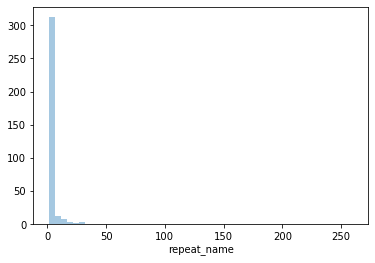

In [591]:
sns.distplot(utars_in_repeats_counts, kde=False)

### Add categories of a few

write out a dictionary for copy/pasting

In [592]:
# utars_in_repeats_counts[utars_in_repeats_counts >= 5].to_dict()

In [593]:
data = {'AluJ_Mim': ('Alu', 'microcebus-specific'),
 '(T)n': ('Simple', 'generic'),
 '(C)n': ('Simple', 'generic'),
 '(G)n': ('Simple', 'generic'),
 '(A)n': ('Simple', 'generic'),
 
 # Long interspersed element-1
 'L1A_Mim': ("LINE", 'microcebus-specific'),
 'A-rich': ('Simple', 'generic'),
 'AluJr': ('Alu', 'primate-specific'),
 # Long terminal repeat (LTR)
 # Table 2 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5753468/
 'ERV1-Mim_I-int': ("LTR", 'microcebus-specific'),
 
 # mammallian-wide interspersed repeat
 #  https://en.wikipedia.org/wiki/Mammalian-wide_interspersed_repeat
 # Short interspersed nuclear elements 
 # http://www.nodai-genome.org/btau/cgi-bin/hgc?hgsid=344&o=21000828&t=21001061&g=rmsk&i=MIRb&c=chr3&l=20998680&r=21002138&db=bosTau4&pix=800
 'MIRb': ('SINE', 'mammal-specific'),
 
 'G-rich': ('Simple', 'generic'),
 
 # Long interspersed element
 'L2a': ('LINE', 'unknown'),
 'GA-rich': ('Simple', 'generic'),
 'L2c': ("Line", 'unknown'),
 '(TT)n': ('Simple', 'unknown'),
 'MIR': ("MIR", 'mammal-specific'),
 'L1B_Mim': ("LINE", 'microcebus-specific'),
 'L1C_Mim': ("LINE", 'microcebus-specific'),
 
 # Long terminal repeat (LTR)
 # Table 2 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5753468/
 'ERV2-1_Mim-I': ("LTR", 'microcebus-specific'),
 'L2b': ("LINE", 'unknown'),
 'MIRc': ("MIR", 'unknown'),
 'L3': ("LINE", 'unknown'),
 'L1MEc': ("LINE", 'unknown'),
 '(GT)n': ('Simple', 'generic'),
 '(TG)n': ('Simple', 'generic'),
 '(AC)n': ('Simple', 'generic'),
       }
repbase_name_to_type = pd.DataFrame(data).T
repbase_name_to_type.columns = ['category', 'specificity']
print(repbase_name_to_type.shape)
repbase_name_to_type.head()

(26, 2)


,category,specificity
AluJ_Mim,Alu,microcebus-specific
(T)n,Simple,generic
(C)n,Simple,generic
(G)n,Simple,generic
(A)n,Simple,generic


In [604]:
utar_dna_repeats = utars_in_repeats_repbase.join(repbase_name_to_type, on='repeat_name')
print(utar_dna_repeats.shape)
utar_dna_repeats.head()

(1951, 6)


,repeat_name,repbase_order,repbase_family,repbase_organism,category,specificity
region_id,,,,,,
NC-033660.1-27699899-27700849---304-0,L1MC5a,LINE,L1,NaN,NaN,NaN
NC-033660.1-9218749-9221399---135-0,MLT1H1,LTR,ERVL-MaLR,Eutheria,NaN,NaN
NC-033660.1-113296599-113298649-+-384-0,(G)n,Simple_repeat,other,root,Simple,generic
NC-033660.1-113296599-113298649-+-384-0,GA-rich,Simple_repeat,Simple_repeat,NaN,Simple,generic
NC-033660.1-101997299-101998899-+-1244-0,L1MC2,LINE,L1,NaN,NaN,NaN


## Join with INFERNAL and DIAMOND results

In [686]:
utar_protein_predictions = utar_homology_predictions.copy()
utar_protein_predictions.columns = "protein__" + utar_protein_predictions.columns
utar_protein_predictions.head()

,protein__subject_description,protein__e_value_inverse__weighted,protein__category_manual,protein__dark_color
region_id,,,,
NC-033660.1-103044949-103045399---164-0,60S ribosomal protein L32,7.629546e+11,ribosomal,#beaed4
NC-033660.1-111179549-111184949---155-0,protein TFG,3.157895e+08,other,#7fc97f
NC-033660.1-27168399-27168999---15612-0,60S ribosomal protein L37a,5.310386e+13,ribosomal,#beaed4
NC-033660.1-38015249-38018599-+-1235-0,neprilysin,3.000000e+10,other,#7fc97f
NC-033660.1-44911399-44911899---601-0,histone deacetylase 2,2.500000e+08,other,#7fc97f


In [691]:
utar_dna = utar_dna_repeats.copy()
utar_dna.columns = 'dna__' + utar_dna.columns
utar_rna = infernal_results_original_good_evalue_likely_rnas_no_go.copy()
utar_rna.columns = 'rna__' + utar_rna.columns

utar_predictions = utar_dna.join(utar_rna)
utar_predictions = utar_predictions.join(utar_protein_predictions)
print(utar_predictions.shape)
utar_predictions.head()

(1951, 15)


,dna__repeat_name,dna__repbase_order,dna__repbase_family,dna__repbase_organism,dna__category,dna__specificity,rna__query_accession,rna__e_value_inverse__weighted,rna__rfam_id_full,rna__rfam_description,rna__rfam_category,protein__subject_description,protein__e_value_inverse__weighted,protein__category_manual,protein__dark_color
NC-033660.1-100839949-100841299---38-0,MIR3,SINE,MIR,Mammalia,NaN,NaN,RF00017,5.659683e+09,Rfam:RF00017,Metazoa_SRP,translation,NaN,NaN,NaN,NaN
NC-033660.1-101997299-101998899-+-1244-0,L1MC2,LINE,L1,NaN,NaN,NaN,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,translation,NaN,NaN,NaN,NaN
NC-033660.1-101997299-101998899-+-1244-0,(G)n,Simple_repeat,other,root,Simple,generic,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,translation,NaN,NaN,NaN,NaN
NC-033660.1-101997299-101998899-+-1244-0,L1MC2,LINE,L1,NaN,NaN,NaN,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,translation,NaN,NaN,NaN,NaN
NC-033660.1-104480199-104484649-+-916-0,MLT2B3,LTR,ERVL,Eutheria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Subset to codnig/noncoding

In [704]:
utar_predictions_coding = utar_predictions.loc[utar_predictions.index.intersection(utar_homology_predictions.index)]
print(utar_predictions_coding.shape)
utar_predictions_coding.head()

(551, 17)


,dna__repeat_name,dna__repbase_order,dna__repbase_family,dna__repbase_organism,dna__category,dna__specificity,rna__query_accession,rna__e_value_inverse__weighted,rna__rfam_id_full,rna__rfam_description,rna__rfam_category,protein__subject_description,protein__e_value_inverse__weighted,protein__category_manual,protein__dark_color,dna__dark_color,dna__light_color
NC-033660.1-111179549-111184949---155-0,L1MA9,LINE,L1,NaN,NaN,NaN,RF00017,9.251864e+07,Rfam:RF00017,Metazoa_SRP,translation,protein TFG,3.157895e+08,other,#7fc97f,#377eb8,#b3cde3
NC-033660.1-44911399-44911899---601-0,(T)n,Simple_repeat,Simple_repeat,NaN,Simple,generic,RF00017,6.572014e+09,Rfam:RF00017,Metazoa_SRP,translation,histone deacetylase 2,2.500000e+08,other,#7fc97f,#e41a1c,#fbb4ae
NC-033660.1-87624599-87626899---848-0,(C)n,Simple_repeat,Simple_repeat,NaN,Simple,generic,RF00017,5.851443e+11,Rfam:RF00017,Metazoa_SRP,translation,60S ribosomal protein L12,2.907578e+11,ribosomal,#beaed4,#e41a1c,#fbb4ae
NC-033661.1-115490999-115493999---112-0,L3,LINE,CR1,Theria_Mammalia,LINE,unknown,RF00017,6.734755e+10,Rfam:RF00017,Metazoa_SRP,translation,high affinity immunoglobulin epsilon receptor...,1.764706e+10,receptor,#386cb0,#377eb8,#b3cde3
NC-033661.1-115490999-115493999---112-0,AluJ_Mim,SINE,Alu,Microcebus_murinus,Alu,microcebus-specific,RF00017,6.734755e+10,Rfam:RF00017,Metazoa_SRP,translation,high affinity immunoglobulin epsilon receptor...,1.764706e+10,receptor,#386cb0,#4daf4a,#ccebc5


In [694]:
utar_predictions_noncoding = utar_predictions.loc[utar_predictions.index.difference(utar_homology_predictions.index)]
print(utar_predictions_noncoding.shape)
utar_predictions_noncoding.head()

(1692, 15)


,dna__repeat_name,dna__repbase_order,dna__repbase_family,dna__repbase_organism,dna__category,dna__specificity,rna__query_accession,rna__e_value_inverse__weighted,rna__rfam_id_full,rna__rfam_description,rna__rfam_category,protein__subject_description,protein__e_value_inverse__weighted,protein__category_manual,protein__dark_color
NC-033660.1-100839949-100841299---38-0,MIR3,SINE,MIR,Mammalia,NaN,NaN,RF00017,5.659683e+09,Rfam:RF00017,Metazoa_SRP,translation,NaN,NaN,NaN,NaN
NC-033660.1-101997299-101998899-+-1244-0,L1MC2,LINE,L1,NaN,NaN,NaN,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,translation,NaN,NaN,NaN,NaN
NC-033660.1-101997299-101998899-+-1244-0,(G)n,Simple_repeat,other,root,Simple,generic,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,translation,NaN,NaN,NaN,NaN
NC-033660.1-101997299-101998899-+-1244-0,L1MC2,LINE,L1,NaN,NaN,NaN,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,translation,NaN,NaN,NaN,NaN
NC-033660.1-104480199-104484649-+-916-0,MLT2B3,LTR,ERVL,Eutheria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [696]:
repbase_family_counts = utar_predictions.dna__repbase_family.value_counts()
repbase_family_counts

Simple_repeat    567
L1               323
Alu              322
other            268
ERV1              94
L2                75
MIR               68
ERVL-MaLR         53
hAT-Charlie       53
ERVK              36
TcMar-Tigger      24
ERVL              21
CR1               15
hAT-Tip100         9
Gypsy              4
RTE-BovB           4
RTE-X              3
MULE-MuDR          2
hAT-Blackjack      2
Helitron           1
hAT                1
tRNA-RTE           1
TcMar-Mariner      1
TcMar-Tc1          1
PiggyBac           1
Name: dna__repbase_family, dtype: int64

In [698]:
repbase_order_counts = utar_predictions.dna__repbase_order.value_counts()
repbase_order_counts

Simple_repeat    714
LINE             379
SINE             329
LTR              171
DNA               82
rRNA               8
snRNA              4
buffer             3
RNA                1
RC                 1
Name: dna__repbase_order, dtype: int64

### Assign repbase/repeatmasker colors

In [700]:
repbase_orders = repbase_order_counts.index
repbase_dark_palette = [rgb2hex(x) for x in sns.color_palette("Set1", n_colors=len(repbase_orders))]
order_to_dark_color = dict(zip(repbase_order_counts.index, repbase_dark_palette))
utar_predictions['dna__dark_color'] = utar_predictions.dna__repbase_order.map(order_to_dark_color)

repbase_light_palette = [rgb2hex(x) for x in sns.color_palette("Pastel1", n_colors=len(repbase_orders))]
order_to_light_color = dict(zip(repbase_order_counts.index, repbase_light_palette))
utar_predictions['dna__light_color'] = utar_predictions.dna__repbase_order.map(order_to_light_color)

utar_predictions.head()

,dna__repeat_name,dna__repbase_order,dna__repbase_family,dna__repbase_organism,dna__category,dna__specificity,rna__query_accession,rna__e_value_inverse__weighted,rna__rfam_id_full,rna__rfam_description,rna__rfam_category,protein__subject_description,protein__e_value_inverse__weighted,protein__category_manual,protein__dark_color,dna__dark_color,dna__light_color
NC-033660.1-100839949-100841299---38-0,MIR3,SINE,MIR,Mammalia,NaN,NaN,RF00017,5.659683e+09,Rfam:RF00017,Metazoa_SRP,translation,NaN,NaN,NaN,NaN,#4daf4a,#ccebc5
NC-033660.1-101997299-101998899-+-1244-0,L1MC2,LINE,L1,NaN,NaN,NaN,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,translation,NaN,NaN,NaN,NaN,#377eb8,#b3cde3
NC-033660.1-101997299-101998899-+-1244-0,(G)n,Simple_repeat,other,root,Simple,generic,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,translation,NaN,NaN,NaN,NaN,#e41a1c,#fbb4ae
NC-033660.1-101997299-101998899-+-1244-0,L1MC2,LINE,L1,NaN,NaN,NaN,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,translation,NaN,NaN,NaN,NaN,#377eb8,#b3cde3
NC-033660.1-104480199-104484649-+-916-0,MLT2B3,LTR,ERVL,Eutheria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#984ea3,#decbe4


In [740]:
utar_predictions.to_parquet('/home/olga/data_sm/tabula-microcebus/analyses/de-novo-orthology/uTAR/utar_predictions.parquet')
utar_predictions.to_csv('/home/olga/data_sm/tabula-microcebus/analyses/de-novo-orthology/uTAR/utar_predictions.csv')

## Plot coding and non-coding overlapping in same figure

### DNA element type

In [636]:
# dark_palette

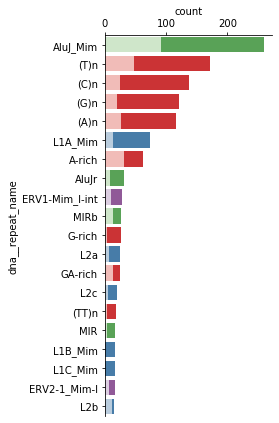

In [705]:
fig, ax = plt.subplots(figsize=(3, 7))
order = utars_in_repeats_counts.head(20).index

y = 'dna__repeat_name'

dark_palette = dict(zip(utar_predictions[y].values, utar_predictions['dna__dark_color']))
light_palette = dict(zip(utar_predictions[y].values, utar_predictions['dna__light_color']))


sns.countplot(y=y, data=utar_predictions, palette=dark_palette, order=order)
sns.countplot(y=y, data=utar_predictions_coding, palette=light_palette, order=order)
# sns.barplot('n_coding', 'rfam_description', data=rfam_counts_df, palette='Pastel1', order=order)
# ax.set(xscale='log')
sns.despine(bottom=True, top=False)
ax.xaxis.set_label_position('top')

### DNA element family

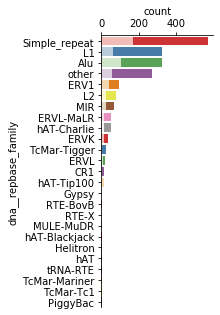

In [706]:
fig, ax = plt.subplots(figsize=(2, 5))
order = repbase_family_counts.index

y = 'dna__repbase_family'

dark_palette = dict(zip(utar_predictions[y].values, utar_predictions['dna__dark_color']))
light_palette = dict(zip(utar_predictions[y].values, utar_predictions['dna__light_color']))


sns.countplot(y=y, data=utar_predictions, palette='Set1', order=order)
sns.countplot(y=y, data=utar_predictions_coding, palette='Pastel1', order=order)
# sns.barplot('n_coding', 'rfam_description', data=rfam_counts_df, palette='Pastel1', order=order)
# ax.set(xscale='log')
sns.despine(bottom=True, top=False)
ax.xaxis.set_label_position('top')

### DNA element *order*

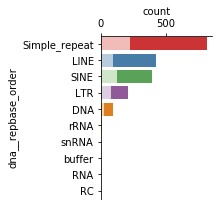

In [708]:
fig, ax = plt.subplots(figsize=(2, 3))
order = repbase_order_counts.index

y = 'dna__repbase_order'

dark_palette = dict(zip(utar_predictions[y].values, utar_predictions['dna__dark_color']))
light_palette = dict(zip(utar_predictions[y].values, utar_predictions['dna__light_color']))


sns.countplot(y=y, data=utar_predictions, palette='Set1', order=order)
sns.countplot(y=y, data=utar_predictions_coding, palette='Pastel1', order=order)
# sns.barplot('n_coding', 'rfam_description', data=rfam_counts_df, palette='Pastel1', order=order)
# ax.set(xscale='log')
sns.despine(bottom=True, top=False)
ax.xaxis.set_label_position('top')

# What's up with the ribosomal predictions

In [711]:
utar_predictions.shape

(1951, 17)

In [709]:
utar_predictions.head()

,dna__repeat_name,dna__repbase_order,dna__repbase_family,dna__repbase_organism,dna__category,dna__specificity,rna__query_accession,rna__e_value_inverse__weighted,rna__rfam_id_full,rna__rfam_description,rna__rfam_category,protein__subject_description,protein__e_value_inverse__weighted,protein__category_manual,protein__dark_color,dna__dark_color,dna__light_color
NC-033660.1-100839949-100841299---38-0,MIR3,SINE,MIR,Mammalia,NaN,NaN,RF00017,5.659683e+09,Rfam:RF00017,Metazoa_SRP,translation,NaN,NaN,NaN,NaN,#4daf4a,#ccebc5
NC-033660.1-101997299-101998899-+-1244-0,L1MC2,LINE,L1,NaN,NaN,NaN,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,translation,NaN,NaN,NaN,NaN,#377eb8,#b3cde3
NC-033660.1-101997299-101998899-+-1244-0,(G)n,Simple_repeat,other,root,Simple,generic,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,translation,NaN,NaN,NaN,NaN,#e41a1c,#fbb4ae
NC-033660.1-101997299-101998899-+-1244-0,L1MC2,LINE,L1,NaN,NaN,NaN,RF00017,4.960531e+09,Rfam:RF00017,Metazoa_SRP,translation,NaN,NaN,NaN,NaN,#377eb8,#b3cde3
NC-033660.1-104480199-104484649-+-916-0,MLT2B3,LTR,ERVL,Eutheria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#984ea3,#decbe4


In [730]:
utar_predictions.query('protein__category_manual == "ribosomal"').head()

,dna__repeat_name,dna__repbase_order,dna__repbase_family,dna__repbase_organism,dna__category,dna__specificity,rna__query_accession,rna__e_value_inverse__weighted,rna__rfam_id_full,rna__rfam_description,rna__rfam_category,protein__subject_description,protein__e_value_inverse__weighted,protein__category_manual,protein__dark_color,dna__dark_color,dna__light_color
NC-033660.1-87624599-87626899---848-0,(C)n,Simple_repeat,Simple_repeat,NaN,Simple,generic,RF00017,5.851443e+11,Rfam:RF00017,Metazoa_SRP,translation,60S ribosomal protein L12,2.907578e+11,ribosomal,#beaed4,#e41a1c,#fbb4ae
NC-033661.1-69410799-69410949---346-0,(C)n,Simple_repeat,Simple_repeat,NaN,Simple,generic,RF00017,6.532592e+09,Rfam:RF00017,Metazoa_SRP,translation,"40S ribosomal protein S4, X isoform",1.111111e+10,ribosomal,#beaed4,#e41a1c,#fbb4ae
NC-033662.1-57450249-57466899-+-4294-0,LTR49-int,LTR,ERV1,Primates,NaN,NaN,RF00017,5.898190e+11,Rfam:RF00017,Metazoa_SRP,translation,40S ribosomal protein S29,1.406832e+12,ribosomal,#beaed4,#984ea3,#decbe4
NC-033662.1-57450249-57466899-+-4294-0,LTR1B_Mim,LTR,ERV1,Microcebus_murinus,NaN,NaN,RF00017,5.898190e+11,Rfam:RF00017,Metazoa_SRP,translation,40S ribosomal protein S29,1.406832e+12,ribosomal,#beaed4,#984ea3,#decbe4
NC-033662.1-57450249-57466899-+-4294-0,LTR46_Mim,LTR,ERVK,Microcebus_murinus,NaN,NaN,RF00017,5.898190e+11,Rfam:RF00017,Metazoa_SRP,translation,40S ribosomal protein S29,1.406832e+12,ribosomal,#beaed4,#984ea3,#decbe4


## Pick a region

In [727]:
utar_id = 'NC-033660.1-87624599-87626899---848-0'

In [728]:
utar_homology.head()

,read_id,subject_id,percent_identity,e_value,bitscore,subject_title,subject_taxid,subject_species,subject_kingdom,subject_superkingdom,subject_phylum,region_id,subject_description_with_predicted,is_predicted,subject_description,utar_id
0,A00111:192:HFVL5DMXX:1:1424:28113:1204,NP_445906.1,100.0,2.500000e-09,59.7,NP_445906.1 nuclear receptor coactivator 3 [Ra...,10116,Rattus norvegicus,Eukaryota,Chordata,NaN,nc-033677.1-40999349-41003199-+-259-0,nuclear receptor coactivator 3,False,nuclear receptor coactivator 3,NC-033677.1-40999349-41003199-+-259-0
1,A00111:192:HFVL5DMXX:1:1424:28113:1204,NP_001361708.1,100.0,2.500000e-09,59.7,NP_001361708.1 nuclear receptor coactivator 3 ...,10090,Mus musculus,Eukaryota,Chordata,NaN,nc-033677.1-40999349-41003199-+-259-0,nuclear receptor coactivator 3 isoform 2,False,nuclear receptor coactivator 3 isoform 2,NC-033677.1-40999349-41003199-+-259-0
2,A00111:192:HFVL5DMXX:1:1424:28113:1204,NP_032705.2,100.0,2.500000e-09,59.7,NP_032705.2 nuclear receptor coactivator 3 iso...,10090,Mus musculus,Eukaryota,Chordata,NaN,nc-033677.1-40999349-41003199-+-259-0,nuclear receptor coactivator 3 isoform 1,False,nuclear receptor coactivator 3 isoform 1,NC-033677.1-40999349-41003199-+-259-0
0,A00111:212:HGMF5DMXX:1:2345:26729:19194,NP_001267090.1,100.0,3.000000e-07,52.8,NP_001267090.1 T-complex protein 1 subunit del...,9598,Pan troglodytes,Eukaryota,Chordata,NaN,nc-033661.1-6618949-6620399-+-1238-0,T-complex protein 1 subunit delta,False,T-complex protein 1 subunit delta,NC-033661.1-6618949-6620399-+-1238-0
1,A00111:212:HGMF5DMXX:1:2345:26729:19194,NP_001126621.1,100.0,3.000000e-07,52.8,NP_001126621.1 T-complex protein 1 subunit del...,9601,Pongo abelii,Eukaryota,Chordata,NaN,nc-033661.1-6618949-6620399-+-1238-0,T-complex protein 1 subunit delta,False,T-complex protein 1 subunit delta,NC-033661.1-6618949-6620399-+-1238-0


In [ ]:
utar_homology['utar_id'] = utar_homology['region_id'].str.upper()
this_utar_protein_predictions = utar_predictions.query('utar_id == @utar_id')
this_utar_protein_predictions.head()

In [732]:
infernal_results_original.head()

,target_name,target_accession,query_name,query_accession,model,model_from,model_to,seq_from,seq_to,strand,trunc,pass,gc,bias,score,e_value,inc,desc1,translation_frame,desc2,jaccard,utar,e_value_inverse
0,A00111:71:H3TTFDMXX:1:2147:13485:5243,-,Metazoa_SRP,RF00017,cm,1,81,10,90,+,3',3,0.64,0.0,47.5,8.500000e-12,!,translation_frame:,2,jaccard:,0.047619,NC-033665.1-60754699-60757649-+-12401-0,1.176471e+11
1,A00111:71:H3TTFDMXX:1:2147:13485:5243,-,Metazoa_SRP,RF00017,cm,1,81,10,90,+,3',3,0.64,0.0,47.5,8.500000e-12,!,translation_frame:,-3,jaccard:,0.095238,NC-033665.1-60754699-60757649-+-12401-0,1.176471e+11
2,A00111:61:H3FYJDMXX:1:2348:31620:25817,-,Metazoa_SRP,RF00017,cm,1,84,6,90,+,3',3,0.65,0.0,45.8,2.500000e-11,!,translation_frame:,-3,jaccard:,0.142857,NC-033665.1-60754699-60757649-+-12401-0,4.000000e+10
3,A00111:212:HGMF5DMXX:2:1143:3631:31203,-,Metazoa_SRP,RF00017,cm,1,78,12,90,+,3',3,0.61,0.0,44.2,7.000000e-11,!,translation_frame:,2,jaccard:,0.000000,NC-033665.1-60754699-60757649-+-12401-0,1.428571e+10
4,A00111:212:HGMF5DMXX:2:1143:3631:31203,-,Metazoa_SRP,RF00017,cm,1,78,12,90,+,3',3,0.61,0.0,44.2,7.000000e-11,!,translation_frame:,-1,jaccard:,0.000000,NC-033665.1-60754699-60757649-+-12401-0,1.428571e+10


In [736]:
this_utar_rna_predictions = infernal_results_original_good_evalue.query('utar == @utar_id')
print(this_utar_rna_predictions.shape)
this_utar_rna_predictions.head()

(331, 23)


,target_name,target_accession,query_name,query_accession,model,model_from,model_to,seq_from,seq_to,strand,trunc,pass,gc,bias,score,e_value,inc,desc1,translation_frame,desc2,jaccard,utar,e_value_inverse
3,A00111:212:HGMF5DMXX:1:2254:14832:21856,-,Metazoa_SRP,RF00017,cm,1,90,1,90,+,3',3,0.60,0.0,47.8,6.900000e-12,!,translation_frame:,3,jaccard:,0.000000,NC-033660.1-87624599-87626899---848-0,1.449275e+11
4,A00111:212:HGMF5DMXX:1:2254:14832:21856,-,Metazoa_SRP,RF00017,cm,1,90,1,90,+,3',3,0.60,0.0,47.8,6.900000e-12,!,translation_frame:,-2,jaccard:,0.000000,NC-033660.1-87624599-87626899---848-0,1.449275e+11
5,A00111:212:HGMF5DMXX:1:2173:5412:23046,-,Metazoa_SRP,RF00017,cm,1,78,12,90,+,3',3,0.66,0.0,47.0,1.100000e-11,!,translation_frame:,2,jaccard:,0.000000,NC-033660.1-87624599-87626899---848-0,9.090909e+10
6,A00111:212:HGMF5DMXX:1:2173:5412:23046,-,Metazoa_SRP,RF00017,cm,1,78,12,90,+,3',3,0.66,0.0,47.0,1.100000e-11,!,translation_frame:,-1,jaccard:,0.045455,NC-033660.1-87624599-87626899---848-0,9.090909e+10
7,A00111:61:H3FYJDMXX:2:2253:26603:25801,-,Metazoa_SRP,RF00017,cm,1,84,7,90,+,3',3,0.67,0.0,43.8,9.200000e-11,!,translation_frame:,2,jaccard:,0.142857,NC-033660.1-87624599-87626899---848-0,1.086957e+10


In [738]:
this_utar_rna_predictions.query_name.value_counts()

Metazoa_SRP    326
KCNQ1OT1_2       4
adapt33_4        1
Name: query_name, dtype: int64

In [739]:
this_utar_rna_predictions.groupby(['target_name', 'translation_frame']).size().head()

target_name                              translation_frame
A00111:192:HFVL5DMXX:1:1105:20030:29105  -2                   1
                                          1                   1
                                          3                   1
A00111:192:HFVL5DMXX:1:1113:20582:12305  -1                   1
A00111:192:HFVL5DMXX:1:1207:9625:2440    -1                   1
dtype: int64